#Captone Project

Nama: Uun Khotimah

Studi Kasus : Text Classification and Insight Extraction from Mental Health Dataset using Traditional Machine Learning with Oversampling Technique

##Import Library

In [1]:
!pip install Sastrawi
!pip install swifter
!pip install openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import re
import nltk

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import MaxAbsScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=0b8d503aa9c8d0ff4140bf3963e7e2092d98fc5a890d4afe6b6bfb7d9e001353
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter


##Mounted Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load Data

Pengambilan dataset bersumber dari platform Kaggle
- Dataset Mental Health: https://www.kaggle.com/code/annastasy/mental-health-sentiment-analysis-nlp-ml/input

## Dataset

In [4]:
dataset_mentalhealth = pd.read_csv('/content/drive/MyDrive/Capstone/dataset/mental_health.csv', encoding='latin-1')
dataset_mentalhealth.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


####Visualisasi Imbalanced

Mengecek distribusi variabel target

/tmp/ipython-input-5-3991829188.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataset_mentalhealth, x='status', palette='pastel')


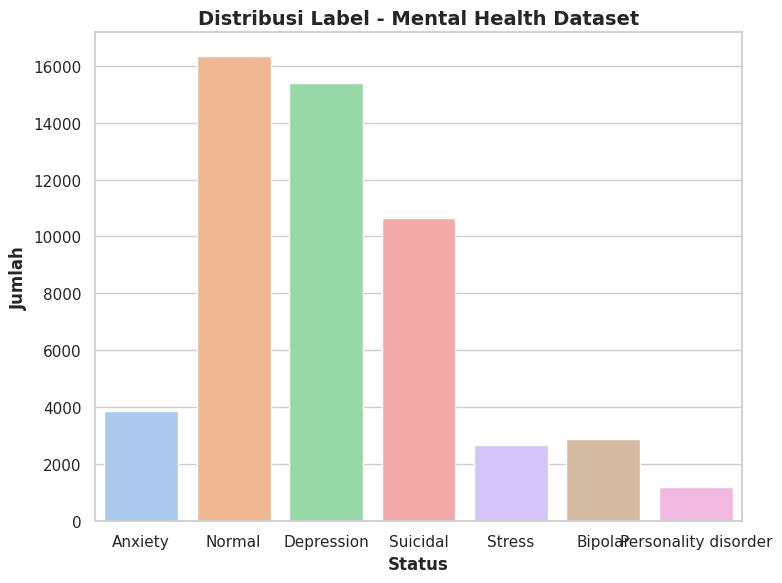

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style seaborn
sns.set(style="whitegrid")

# Ukuran plot
plt.figure(figsize=(8, 6))

# Plot distribusi label untuk dataset mental health
sns.countplot(data=dataset_mentalhealth, x='status', palette='pastel')

# Judul dan label
plt.title('Distribusi Label - Mental Health Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Status', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')

# Tampilkan plot
plt.tight_layout()
plt.show()

Dari diagram tersebut variabel target dalam dataset kita tidak seimbang. Ketidakseimbangan ini dapat mempengaruhi kinerja model, sehingga kita perlu menanganinya agar prediksi yang dihasilkan lebih akurat dan adil.

####Preprocessing

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

#####Cleaning Dataset

In [7]:
# Path folder dataset di Google Drive
dataset_path = "/content/drive/MyDrive/Capstone/dataset/"
processed_path = "/content/drive/MyDrive/Capstone/dataset/processed/"

# Buat folder processed jika belum ada
os.makedirs(processed_path, exist_ok=True)

# List dataset dan konfigurasi preprocessing awal
raw_datasets = {
    "mental_health.csv": {
        "drop": ["Unnamed: 0"],
        "rename": {"statement": "sentiment_mental_health", "status": "labels_mental_health"}
    }
}

# Proses preprocessing awal
for file, config in raw_datasets.items():
    df = pd.read_csv(dataset_path + file, encoding="latin-1")

    if "drop" in config:
        df = df.drop(columns=config["drop"])

    if "rename" in config:
        df = df.rename(columns=config["rename"])

    output_file = processed_path + file.replace(".csv", "_processed.csv")
    df.to_csv(output_file, index=False)

# Path ke dataset yang sudah diproses
processed_datasets = {
    "mental_health_processed.csv": "mental_health"
}

# Fungsi pembersihan teks
def cleaning(Text):
    Text = re.sub(r'\$\w*', '', Text)
    Text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', ' ', Text)
    Text = re.sub('&quot;', " ", Text)
    Text = re.sub(r"\d+", " ", str(Text))
    Text = re.sub(r"\b[a-zA-Z]\b", "", str(Text))
    Text = re.sub(r"#\S+", "", Text)
    Text = re.sub(r"[^\w\s]", " ", str(Text))
    Text = re.sub(r'(.)\1+', r'\1\1', Text)
    Text = re.sub(r"\s+", " ", str(Text))
    Text = re.sub(r'\b\w{1,2}\b', '', Text)
    Text = re.sub(r'\s\s+', ' ', Text)
    Text = re.sub(r'^RT[\s]+', '', Text)
    Text = re.sub(r'^b[\s]+', '', Text)
    Text = re.sub(r'^link[\s]+', '', Text)
    return Text.strip()

# Fungsi menghapus emoji
def remove_emoji(Text):
    emoji = re.compile("[" +
                       u"\U0001F600-\U0001F64F"
                       u"\U0001F300-\U0001F5FF"
                       u"\U0001F680-\U0001F6FF"
                       u"\U0001F1E0-\U0001F1FF"
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       "]", flags=re.UNICODE)
    return emoji.sub(r'', Text)

# Fungsi membersihkan dataset
def clean_datasets(datasets_map):
    cleaned_datasets = {}

    for file, dataset_name in datasets_map.items():
        df = pd.read_csv(processed_path + file, encoding="latin-1")

        # Ambil kolom teks dan label
        text_column = [col for col in df.columns if col.startswith("sentiment")][0]
        label_column = [col for col in df.columns if col.startswith("label")][0]

        # Buat kolom hasil cleaning sesuai nama dataset
        cleaning_column_name = f"cleaning_{dataset_name}"

        # Terapkan fungsi cleaning
        df[cleaning_column_name] = df[text_column].astype(str).apply(lambda x: remove_emoji(cleaning(x)))

        # Susun ulang kolom
        df = df[[text_column, label_column, cleaning_column_name]]

        cleaned_datasets[file] = df

        print(f"\n✅ Hasil Cleaned {file} dataset:")
        display(df.head(10))

    return cleaned_datasets

# Jalankan proses pembersihan
datasets_cleaned = clean_datasets(processed_datasets)


✅ Hasil Cleaned mental_health_processed.csv dataset:


,sentiment_mental_health,labels_mental_health,cleaning_mental_health
0,oh my gosh,Anxiety,gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,All wrong back off dear forward doubt Stay res...
3,I've shifted my focus to something else but I'...,Anxiety,shifted focus something else but still worried
4,"I'm restless and restless, it's been a month n...",Anxiety,restless and restless been month now boy What ...
5,"every break, you must be nervous, like somethi...",Anxiety,every break you must nervous like something wr...
6,"I feel scared, anxious, what can I do? And may...",Anxiety,feel scared anxious what can And may family pr...
7,Have you ever felt nervous but didn't know why?,Anxiety,Have you ever felt nervous but didn know why
8,"I haven't slept well for 2 days, it's like I'm...",Anxiety,haven slept well for days like restless why huh
9,"I'm really worried, I want to cry.",Anxiety,really worried want cry


#####Case Folding Dataset

In [8]:
# Proses Case Folding setelah cleaning dataset
casefolding_results = {}

for file, df in datasets_cleaned.items():
    dataset_name = processed_datasets[file]  # ambil nama dataset
    cleaning_col = f"cleaning_{dataset_name}"
    casefolding_col = f"casefolding_{dataset_name}"

    if cleaning_col in df.columns:
        df[casefolding_col] = df[cleaning_col].str.lower()
        casefolding_results[file] = df[[cleaning_col, casefolding_col]]

        print(f"\n✔ Case folding: {cleaning_col} → {casefolding_col}")
        display(df[[cleaning_col, casefolding_col]].head(10))
    else:
        print(f"⚠ Kolom {cleaning_col} tidak ditemukan dalam {file}")


✔ Case folding: cleaning_mental_health → casefolding_mental_health


,cleaning_mental_health,casefolding_mental_health
0,gosh,gosh
1,trouble sleeping confused mind restless heart ...,trouble sleeping confused mind restless heart ...
2,All wrong back off dear forward doubt Stay res...,all wrong back off dear forward doubt stay res...
3,shifted focus something else but still worried,shifted focus something else but still worried
4,restless and restless been month now boy What ...,restless and restless been month now boy what ...
5,every break you must nervous like something wr...,every break you must nervous like something wr...
6,feel scared anxious what can And may family pr...,feel scared anxious what can and may family pr...
7,Have you ever felt nervous but didn know why,have you ever felt nervous but didn know why
8,haven slept well for days like restless why huh,haven slept well for days like restless why huh
9,really worried want cry,really worried want cry


#####Tokenizing Dataset

In [9]:
from nltk.tokenize import word_tokenize

# Proses Tokenizing
tokenizing_results = {}

for file, df in casefolding_results.items():
    dataset_name = processed_datasets[file]  # ⬅️ Pindahkan ini ke dalam loop!
    casefolding_col = f"casefolding_{dataset_name}"
    tokenizing_col = f"tokenizing_{dataset_name}"

    if casefolding_col in df.columns:
        # Hindari SettingWithCopyWarning → gunakan .loc
        df.loc[:, tokenizing_col] = df[casefolding_col].apply(lambda text: [repr(word) for word in word_tokenize(text)])
        tokenizing_results[file] = df[[casefolding_col, tokenizing_col]]

        print(f"✔ Hasil Tokenizing: {casefolding_col} → {tokenizing_col}")
        display(df[[casefolding_col, tokenizing_col]].head(10))
    else:
        print(f"⚠ Kolom {casefolding_col} tidak ditemukan dalam {file}")

✔ Hasil Tokenizing: casefolding_mental_health → tokenizing_mental_health


/tmp/ipython-input-9-2126191904.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, tokenizing_col] = df[casefolding_col].apply(lambda text: [repr(word) for word in word_tokenize(text)])


,casefolding_mental_health,tokenizing_mental_health
0,gosh,['gosh']
1,trouble sleeping confused mind restless heart ...,"['trouble', 'sleeping', 'confused', 'mind', 'r..."
2,all wrong back off dear forward doubt stay res...,"['all', 'wrong', 'back', 'off', 'dear', 'forwa..."
3,shifted focus something else but still worried,"['shifted', 'focus', 'something', 'else', 'but..."
4,restless and restless been month now boy what ...,"['restless', 'and', 'restless', 'been', 'month..."
5,every break you must nervous like something wr...,"['every', 'break', 'you', 'must', 'nervous', '..."
6,feel scared anxious what can and may family pr...,"['feel', 'scared', 'anxious', 'what', 'can', '..."
7,have you ever felt nervous but didn know why,"['have', 'you', 'ever', 'felt', 'nervous', 'bu..."
8,haven slept well for days like restless why huh,"['haven', 'slept', 'well', 'for', 'days', 'lik..."
9,really worried want cry,"['really', 'worried', 'want', 'cry']"


#####Filtering Stopwords

In [10]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Stopwords bahasa Inggris + tambahan
stop_words = set(stopwords.words("english"))
extra_stopwords = {'u', 'im', 'dont', 'cant', 'ive', 'ur', 'ya', 'ok', 'okay', 'youre', 'thats', 'wanna', 'gonna'}
all_stopwords = stop_words.union(extra_stopwords)

# Proses Filtering Stopword
stopword_results = {}

for file, df in tokenizing_results.items():
    dataset_name = processed_datasets[file]  # ⬅️ penting: diambil tiap iterasi

    tokenizing_col = f"tokenizing_{dataset_name}"
    stopword_col = f"stopword_filtered_{dataset_name}"

    if tokenizing_col in df.columns:
        # Gunakan .loc untuk hindari SettingWithCopyWarning
        df.loc[:, stopword_col] = df[tokenizing_col].apply(
            lambda tokens: [word for word in tokens if word.lower().strip("'") not in all_stopwords]
        )

        # Simpan hasil
        stopword_results[file] = df[[tokenizing_col, stopword_col]]

        print(f"\n✔ Hasil Stopword Filtering untuk dataset: {dataset_name}")
        display(df[[tokenizing_col, stopword_col]].head(10))
    else:
        print(f"⚠ Kolom {tokenizing_col} tidak ditemukan dalam {file}")


✔ Hasil Stopword Filtering untuk dataset: mental_health


,tokenizing_mental_health,stopword_filtered_mental_health
0,['gosh'],['gosh']
1,"['trouble', 'sleeping', 'confused', 'mind', 'r...","['trouble', 'sleeping', 'confused', 'mind', 'r..."
2,"['all', 'wrong', 'back', 'off', 'dear', 'forwa...","['wrong', 'back', 'dear', 'forward', 'doubt', ..."
3,"['shifted', 'focus', 'something', 'else', 'but...","['shifted', 'focus', 'something', 'else', 'sti..."
4,"['restless', 'and', 'restless', 'been', 'month...","['restless', 'restless', 'month', 'boy', 'mean']"
5,"['every', 'break', 'you', 'must', 'nervous', '...","['every', 'break', 'must', 'nervous', 'like', ..."
6,"['feel', 'scared', 'anxious', 'what', 'can', '...","['feel', 'scared', 'anxious', 'may', 'family',..."
7,"['have', 'you', 'ever', 'felt', 'nervous', 'bu...","['ever', 'felt', 'nervous', 'know']"
8,"['haven', 'slept', 'well', 'for', 'days', 'lik...","['slept', 'well', 'days', 'like', 'restless', ..."
9,"['really', 'worried', 'want', 'cry']","['really', 'worried', 'want', 'cry']"


#####Lemmatization

In [11]:
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Unduh resource NLTK yang dibutuhkan
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng') # Added this line

lemmatizer = WordNetLemmatizer()

# Fungsi bantu konversi POS ke format WordNet
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN  # default

# Proses Lemmatization
lemmatization_results = {}

for file, df in stopword_results.items():
    dataset_name = processed_datasets[file]  # ambil nama dataset

    stopword_col = f"stopword_filtered_{dataset_name}"
    lemmatization_col = f"lemmatization_{dataset_name}"

    if stopword_col in df.columns:
        # Gunakan .loc untuk mencegah SettingWithCopyWarning
        df.loc[:, lemmatization_col] = df[stopword_col].apply(lambda tokens: [
            lemmatizer.lemmatize(word.strip("'"), get_wordnet_pos(tag))
            for word, tag in pos_tag([word.strip("'") for word in tokens])
        ])

        # Simpan hasil
        lemmatization_results[file] = df[[stopword_col, lemmatization_col]]

        print(f"\n✔ Hasil Lemmatization untuk dataset: {dataset_name}")
        display(df[[stopword_col, lemmatization_col]].head(10))
    else:
        print(f"⚠ Kolom {stopword_col} tidak ditemukan dalam {file}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.



✔ Hasil Lemmatization untuk dataset: mental_health


,stopword_filtered_mental_health,lemmatization_mental_health
0,['gosh'],[gosh]
1,"['trouble', 'sleeping', 'confused', 'mind', 'r...","[trouble, sleep, confuse, mind, restless, hear..."
2,"['wrong', 'back', 'dear', 'forward', 'doubt', ...","[wrong, back, dear, forward, doubt, stay, rest..."
3,"['shifted', 'focus', 'something', 'else', 'sti...","[shift, focus, something, else, still, worried]"
4,"['restless', 'restless', 'month', 'boy', 'mean']","[restless, restless, month, boy, mean]"
5,"['every', 'break', 'must', 'nervous', 'like', ...","[every, break, must, nervous, like, something,..."
6,"['feel', 'scared', 'anxious', 'may', 'family',...","[feel, scar, anxious, may, family, protect]"
7,"['ever', 'felt', 'nervous', 'know']","[ever, felt, nervous, know]"
8,"['slept', 'well', 'days', 'like', 'restless', ...","[slept, well, day, like, restless, huh]"
9,"['really', 'worried', 'want', 'cry']","[really, worried, want, cry]"


####TF-IDF

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Dictionary untuk menyimpan hasil TF-IDF
tfidf_results = {}

# Proses setiap file hasil lemmatization
for file, df in lemmatization_results.items():
    # Pastikan file ada dalam mapping
    if file not in processed_datasets:
        print(f"⚠️ {file} tidak ditemukan di processed_datasets. Lewati.")
        continue

    dataset_name = processed_datasets[file]
    lemmatization_col = f"lemmatization_{dataset_name}"

    # Pastikan kolom lemmatization tersedia
    if lemmatization_col not in df.columns:
        print(f"⚠️ Kolom '{lemmatization_col}' tidak ditemukan dalam {file}. Lewati.")
        continue

    # Gabungkan token hasil lemmatization jadi string untuk TF-IDF
    df = df.copy()  # agar aman dari SettingWithCopyWarning
    df["X_text"] = df[lemmatization_col].apply(lambda tokens: " ".join(tokens))

    # Inisialisasi dan fit TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    X_tfidf = vectorizer.fit_transform(df["X_text"])

    # Simpan hasil TF-IDF ke dictionary
    tfidf_results[file] = X_tfidf

    # Tampilkan info
    print(f"\n🔹 TF-IDF selesai untuk: {file}")
    print(f"   → Jumlah dokumen: {X_tfidf.shape[0]}, Jumlah fitur: {X_tfidf.shape[1]}")

    # Opsional: tampilkan 10 baris pertama hasil TF-IDF
    df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
    display(df_tfidf.head(10))


🔹 TF-IDF selesai untuk: mental_health_processed.csv
   → Jumlah dokumen: 53043, Jumlah fitur: 49412


,__affiliation__,__background__,__compensation__,__i,__link__,__melanieright,__target,__the,__therealskp,__who,...,â¼ã,â½ainã,â½m,â½nes,â½s,â½t,â½tã,â½ã,â¾kacil,â¾ã
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


####Modelling


⚙️ Memproses dataset: mental_health (mental_health_processed.csv)


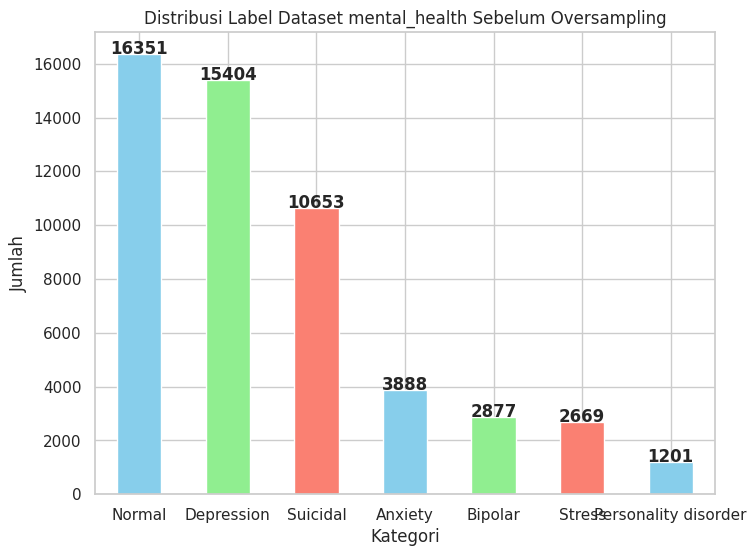


🔧 Skenario: Naive Bayes (tanpa SMOTE)

📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (tanpa SMOTE)) - Fold 1:
                      precision    recall  f1-score   support

             Anxiety       0.69      0.66      0.67       389
             Bipolar       0.65      0.61      0.63       288
          Depression       0.49      0.62      0.55      1541
              Normal       0.90      0.70      0.79      1635
Personality disorder       0.24      0.42      0.30       120
              Stress       0.41      0.32      0.36       267
            Suicidal       0.57      0.55      0.56      1065

            accuracy                           0.61      5305
           macro avg       0.56      0.55      0.55      5305
        weighted avg       0.65      0.61      0.62      5305

Akurasi: 61.30%


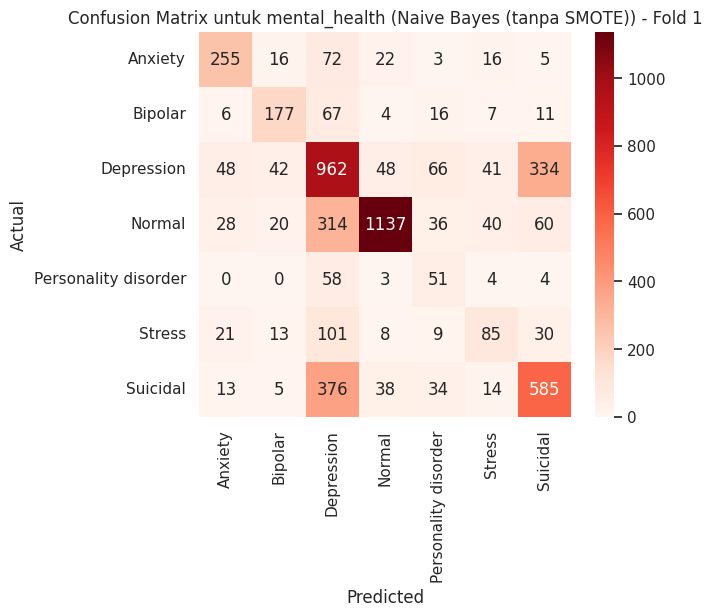


📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (tanpa SMOTE)) - Fold 2:
                      precision    recall  f1-score   support

             Anxiety       0.70      0.68      0.69       389
             Bipolar       0.61      0.63      0.62       288
          Depression       0.51      0.64      0.57      1541
              Normal       0.93      0.72      0.81      1635
Personality disorder       0.27      0.46      0.34       120
              Stress       0.42      0.30      0.35       267
            Suicidal       0.56      0.55      0.55      1065

            accuracy                           0.63      5305
           macro avg       0.57      0.57      0.56      5305
        weighted avg       0.66      0.63      0.64      5305

Akurasi: 62.81%


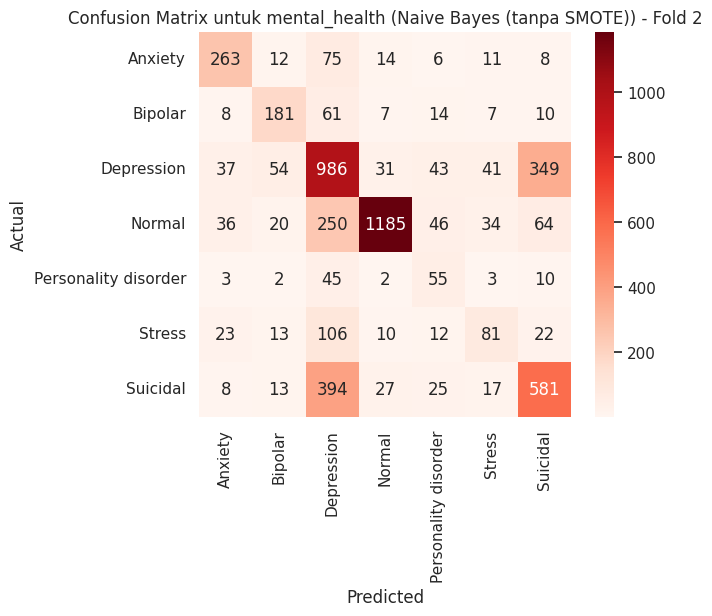


📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (tanpa SMOTE)) - Fold 3:
                      precision    recall  f1-score   support

             Anxiety       0.67      0.67      0.67       389
             Bipolar       0.63      0.62      0.62       287
          Depression       0.51      0.62      0.56      1541
              Normal       0.91      0.71      0.80      1635
Personality disorder       0.24      0.45      0.31       121
              Stress       0.44      0.31      0.36       267
            Suicidal       0.56      0.56      0.56      1065

            accuracy                           0.62      5305
           macro avg       0.57      0.56      0.56      5305
        weighted avg       0.65      0.62      0.63      5305

Akurasi: 62.15%


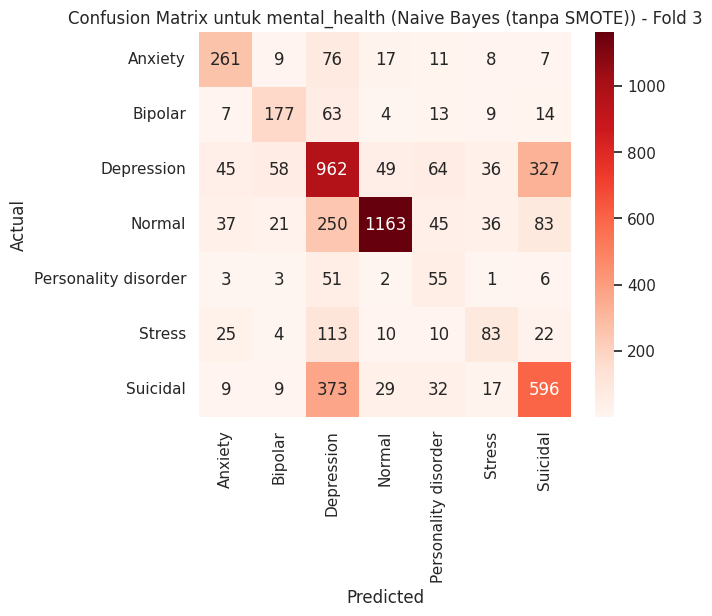


📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (tanpa SMOTE)) - Fold 4:
                      precision    recall  f1-score   support

             Anxiety       0.68      0.65      0.66       389
             Bipolar       0.65      0.57      0.61       287
          Depression       0.49      0.62      0.55      1540
              Normal       0.91      0.72      0.81      1635
Personality disorder       0.30      0.53      0.38       120
              Stress       0.44      0.30      0.36       267
            Suicidal       0.54      0.51      0.52      1066

            accuracy                           0.61      5304
           macro avg       0.57      0.56      0.55      5304
        weighted avg       0.64      0.61      0.62      5304

Akurasi: 61.14%


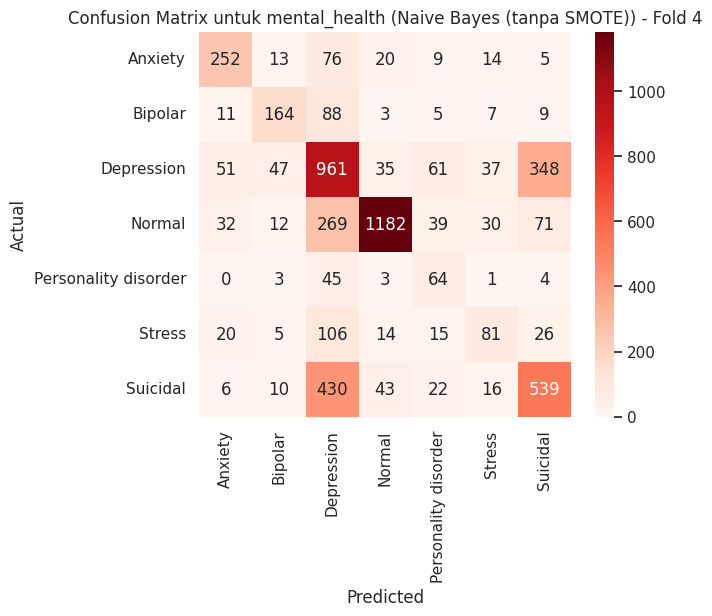


📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (tanpa SMOTE)) - Fold 5:
                      precision    recall  f1-score   support

             Anxiety       0.70      0.69      0.70       389
             Bipolar       0.69      0.65      0.67       287
          Depression       0.53      0.64      0.58      1540
              Normal       0.90      0.71      0.79      1635
Personality disorder       0.29      0.54      0.38       120
              Stress       0.46      0.30      0.36       267
            Suicidal       0.55      0.57      0.56      1066

            accuracy                           0.63      5304
           macro avg       0.59      0.59      0.58      5304
        weighted avg       0.66      0.63      0.64      5304

Akurasi: 63.14%


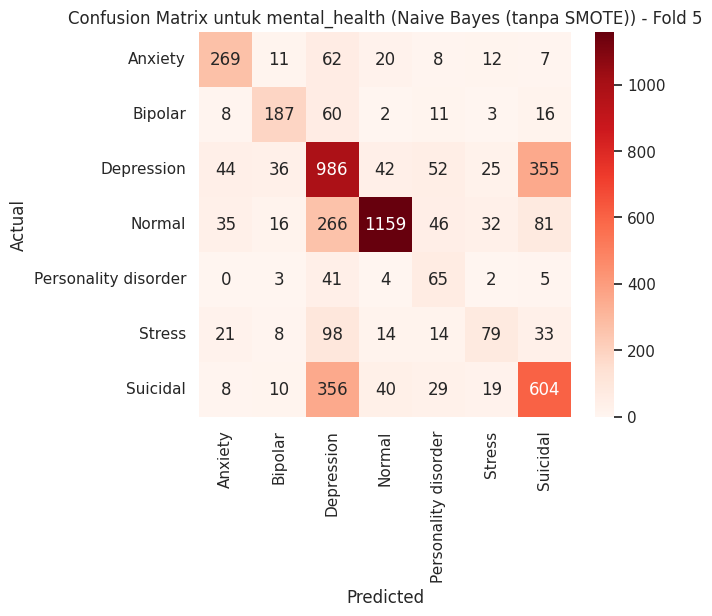


📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (tanpa SMOTE)) - Fold 6:
                      precision    recall  f1-score   support

             Anxiety       0.69      0.70      0.70       389
             Bipolar       0.66      0.63      0.65       288
          Depression       0.49      0.62      0.55      1540
              Normal       0.91      0.71      0.79      1635
Personality disorder       0.26      0.43      0.32       120
              Stress       0.41      0.29      0.34       266
            Suicidal       0.53      0.51      0.52      1066

            accuracy                           0.61      5304
           macro avg       0.56      0.56      0.55      5304
        weighted avg       0.64      0.61      0.62      5304

Akurasi: 60.97%


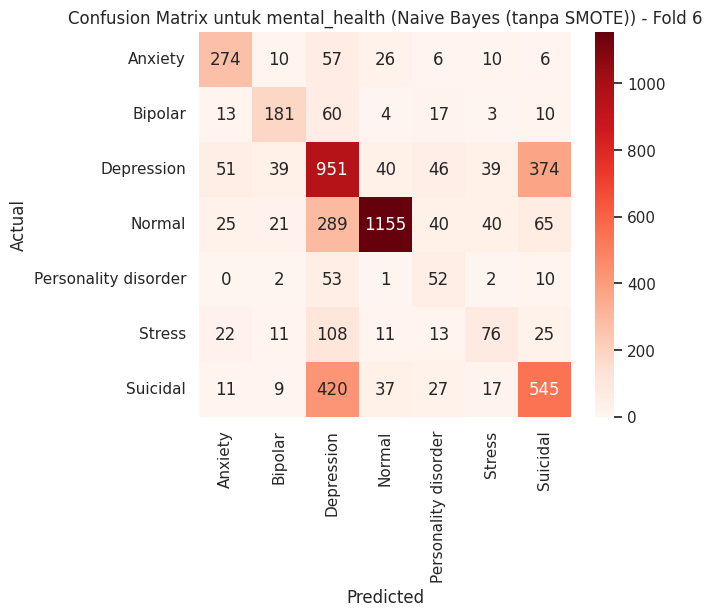


📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (tanpa SMOTE)) - Fold 7:
                      precision    recall  f1-score   support

             Anxiety       0.72      0.74      0.73       389
             Bipolar       0.66      0.64      0.65       288
          Depression       0.51      0.62      0.56      1540
              Normal       0.91      0.72      0.81      1635
Personality disorder       0.27      0.48      0.34       120
              Stress       0.47      0.37      0.42       267
            Suicidal       0.55      0.54      0.55      1065

            accuracy                           0.63      5304
           macro avg       0.58      0.59      0.58      5304
        weighted avg       0.66      0.63      0.64      5304

Akurasi: 62.93%


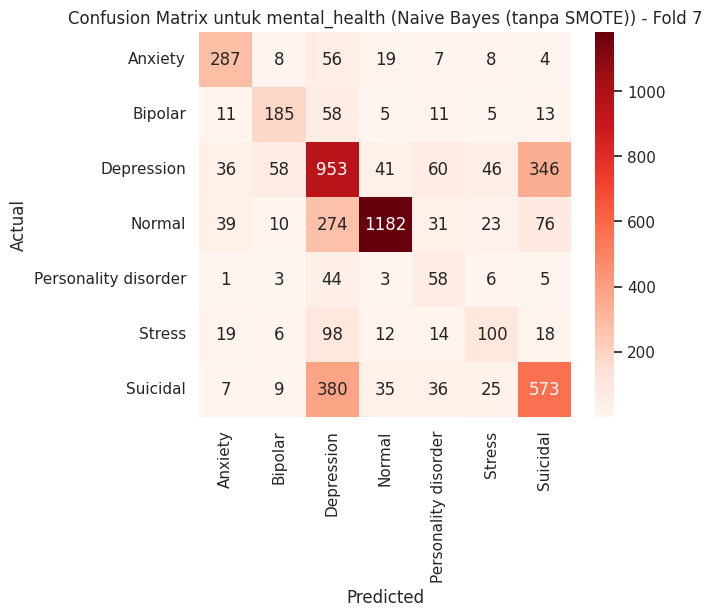


📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (tanpa SMOTE)) - Fold 8:
                      precision    recall  f1-score   support

             Anxiety       0.69      0.68      0.69       389
             Bipolar       0.69      0.57      0.62       288
          Depression       0.52      0.63      0.57      1540
              Normal       0.91      0.73      0.81      1635
Personality disorder       0.23      0.45      0.31       120
              Stress       0.43      0.34      0.38       267
            Suicidal       0.56      0.56      0.56      1065

            accuracy                           0.63      5304
           macro avg       0.58      0.57      0.56      5304
        weighted avg       0.66      0.63      0.64      5304

Akurasi: 62.78%


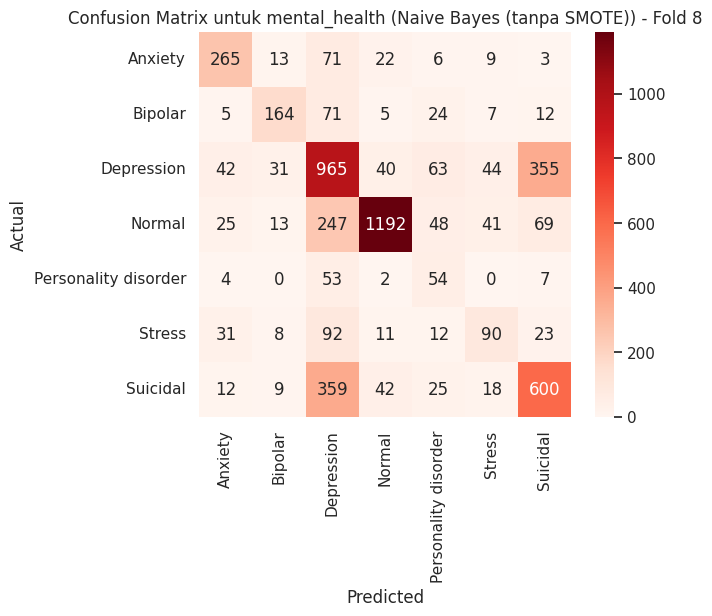


📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (tanpa SMOTE)) - Fold 9:
                      precision    recall  f1-score   support

             Anxiety       0.67      0.64      0.66       388
             Bipolar       0.64      0.60      0.62       288
          Depression       0.50      0.62      0.56      1540
              Normal       0.91      0.71      0.79      1636
Personality disorder       0.23      0.45      0.30       120
              Stress       0.39      0.31      0.34       267
            Suicidal       0.55      0.54      0.54      1065

            accuracy                           0.61      5304
           macro avg       0.56      0.55      0.54      5304
        weighted avg       0.64      0.61      0.62      5304

Akurasi: 61.09%


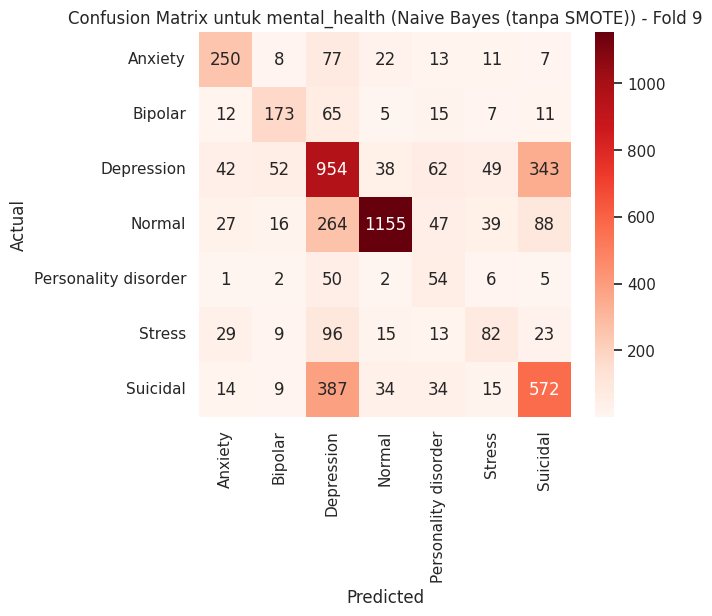


📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (tanpa SMOTE)) - Fold 10:
                      precision    recall  f1-score   support

             Anxiety       0.68      0.68      0.68       388
             Bipolar       0.66      0.61      0.63       288
          Depression       0.52      0.63      0.57      1541
              Normal       0.91      0.74      0.81      1635
Personality disorder       0.30      0.47      0.36       120
              Stress       0.41      0.29      0.34       267
            Suicidal       0.56      0.56      0.56      1065

            accuracy                           0.63      5304
           macro avg       0.58      0.57      0.56      5304
        weighted avg       0.66      0.63      0.64      5304

Akurasi: 63.07%


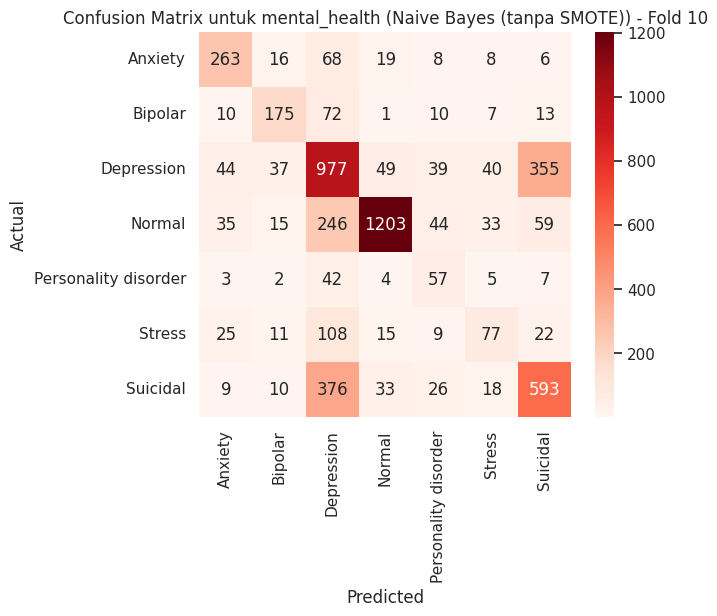


🔹 Rata-rata Hasil K-Fold Cross Validation untuk mental_health (Naive Bayes (tanpa SMOTE)):
Precision: 57.15%
Recall: 56.59%
F1-Score: 56.03%
Akurasi: 62.14%
****************************************************************************************************


🔧 Skenario: Naive Bayes (dengan SMOTE)


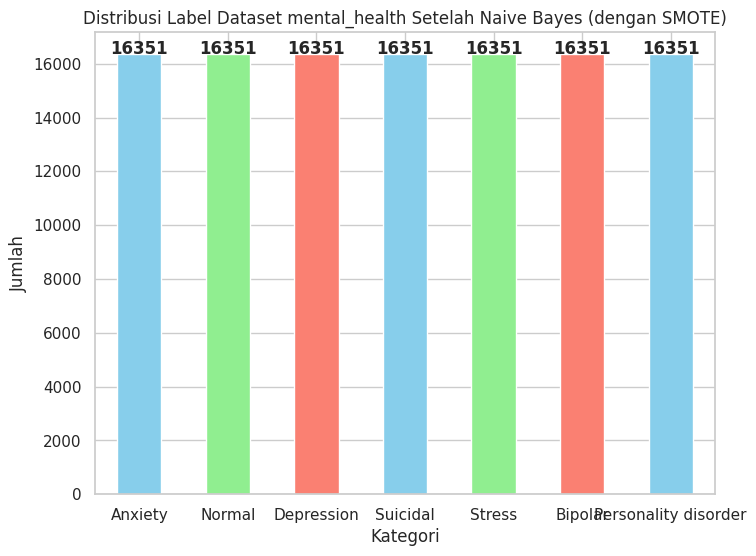


📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (dengan SMOTE)) - Fold 1:
                      precision    recall  f1-score   support

             Anxiety       0.87      0.93      0.90      1636
             Bipolar       0.86      0.90      0.88      1635
          Depression       0.66      0.50      0.57      1635
              Normal       0.91      0.64      0.75      1635
Personality disorder       0.80      0.99      0.88      1635
              Stress       0.84      0.83      0.83      1635
            Suicidal       0.64      0.77      0.70      1635

            accuracy                           0.79     11446
           macro avg       0.80      0.79      0.79     11446
        weighted avg       0.80      0.79      0.79     11446

Akurasi: 79.43%


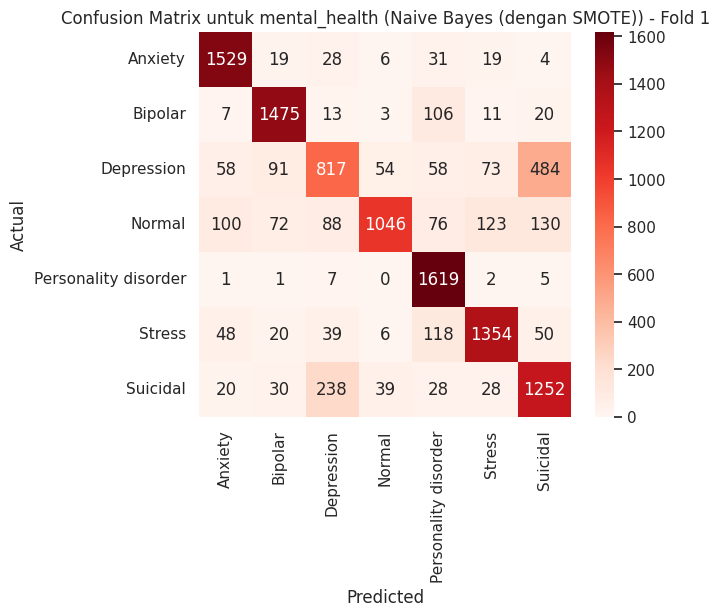


📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (dengan SMOTE)) - Fold 2:
                      precision    recall  f1-score   support

             Anxiety       0.86      0.92      0.89      1635
             Bipolar       0.86      0.89      0.88      1635
          Depression       0.64      0.47      0.54      1635
              Normal       0.90      0.63      0.74      1636
Personality disorder       0.79      0.99      0.88      1635
              Stress       0.84      0.82      0.83      1635
            Suicidal       0.63      0.77      0.69      1635

            accuracy                           0.78     11446
           macro avg       0.79      0.78      0.78     11446
        weighted avg       0.79      0.78      0.78     11446

Akurasi: 78.46%


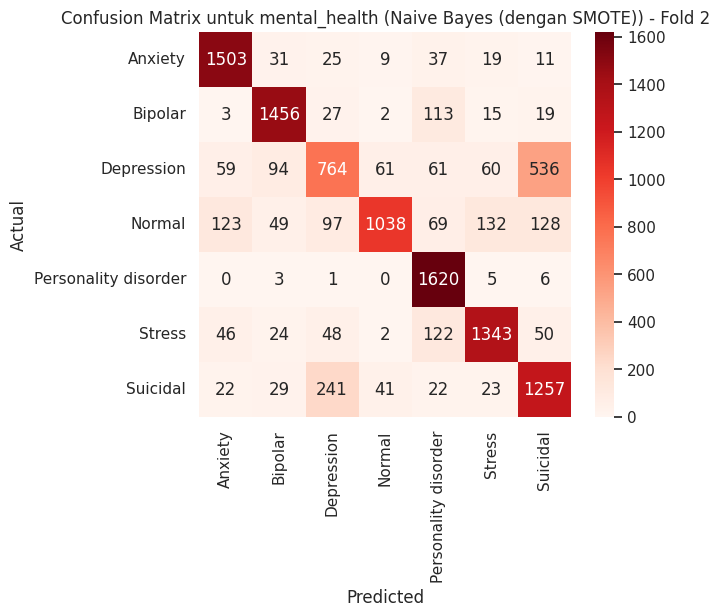


📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (dengan SMOTE)) - Fold 3:
                      precision    recall  f1-score   support

             Anxiety       0.84      0.94      0.89      1635
             Bipolar       0.87      0.90      0.89      1635
          Depression       0.66      0.50      0.57      1636
              Normal       0.91      0.62      0.73      1635
Personality disorder       0.79      0.99      0.88      1635
              Stress       0.84      0.81      0.83      1635
            Suicidal       0.64      0.76      0.69      1635

            accuracy                           0.79     11446
           macro avg       0.79      0.79      0.78     11446
        weighted avg       0.79      0.79      0.78     11446

Akurasi: 78.83%


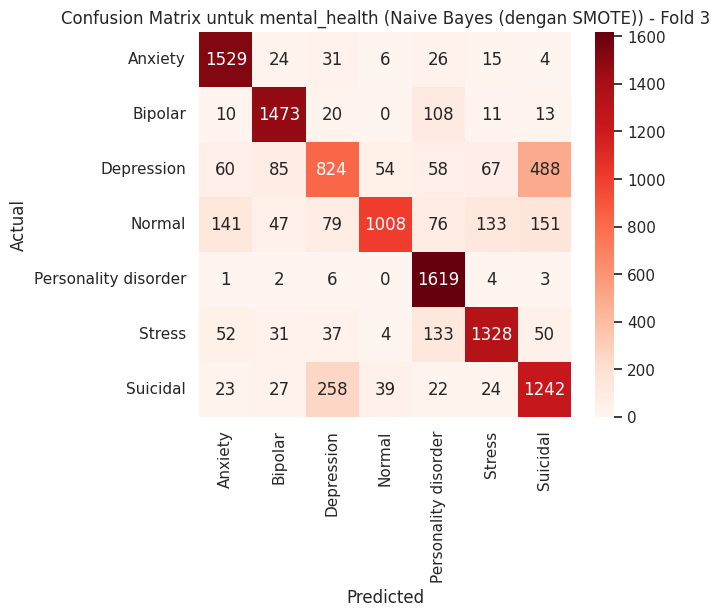


📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (dengan SMOTE)) - Fold 4:
                      precision    recall  f1-score   support

             Anxiety       0.85      0.93      0.89      1635
             Bipolar       0.87      0.91      0.89      1635
          Depression       0.63      0.49      0.55      1635
              Normal       0.92      0.64      0.75      1635
Personality disorder       0.80      0.99      0.89      1635
              Stress       0.85      0.81      0.83      1635
            Suicidal       0.64      0.77      0.70      1636

            accuracy                           0.79     11446
           macro avg       0.80      0.79      0.79     11446
        weighted avg       0.80      0.79      0.79     11446

Akurasi: 79.26%


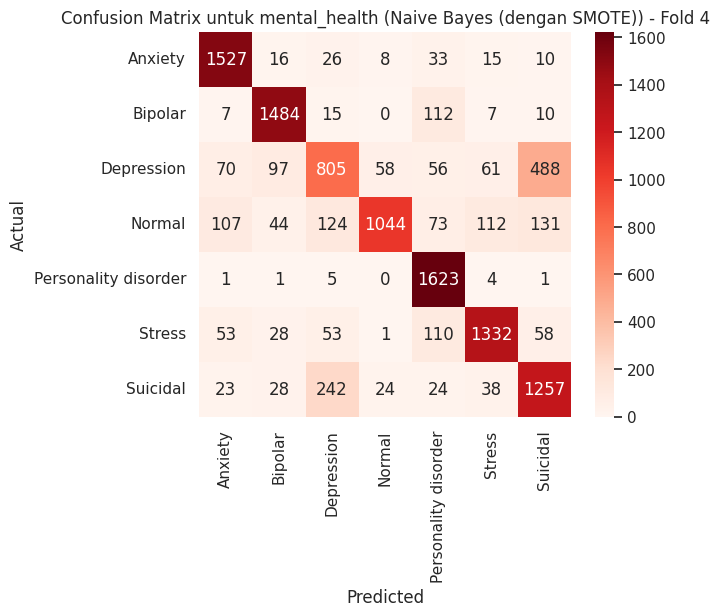


📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (dengan SMOTE)) - Fold 5:
                      precision    recall  f1-score   support

             Anxiety       0.85      0.92      0.89      1635
             Bipolar       0.86      0.91      0.88      1635
          Depression       0.62      0.49      0.55      1635
              Normal       0.90      0.63      0.74      1635
Personality disorder       0.81      0.99      0.89      1635
              Stress       0.85      0.82      0.83      1636
            Suicidal       0.62      0.74      0.68      1635

            accuracy                           0.79     11446
           macro avg       0.79      0.79      0.78     11446
        weighted avg       0.79      0.79      0.78     11446

Akurasi: 78.53%


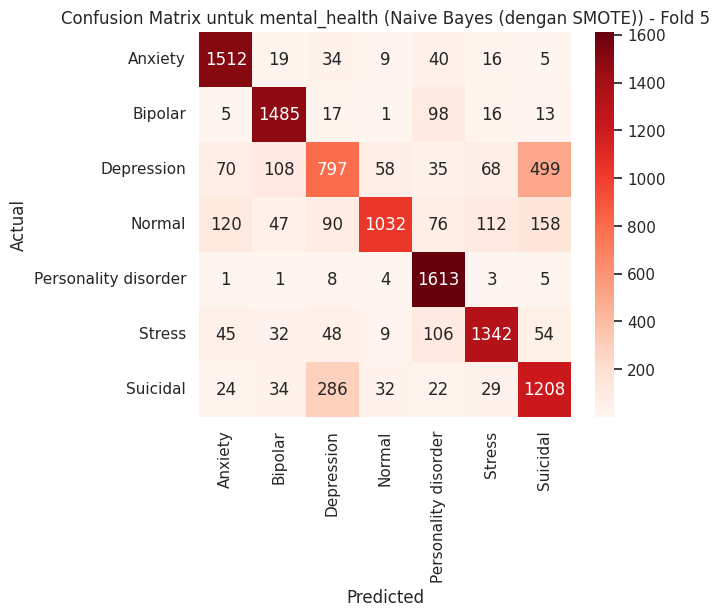


📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (dengan SMOTE)) - Fold 6:
                      precision    recall  f1-score   support

             Anxiety       0.84      0.93      0.88      1635
             Bipolar       0.88      0.91      0.90      1636
          Depression       0.65      0.49      0.56      1635
              Normal       0.93      0.62      0.74      1635
Personality disorder       0.80      0.99      0.88      1635
              Stress       0.85      0.82      0.84      1635
            Suicidal       0.63      0.77      0.69      1635

            accuracy                           0.79     11446
           macro avg       0.80      0.79      0.78     11446
        weighted avg       0.80      0.79      0.78     11446

Akurasi: 79.09%


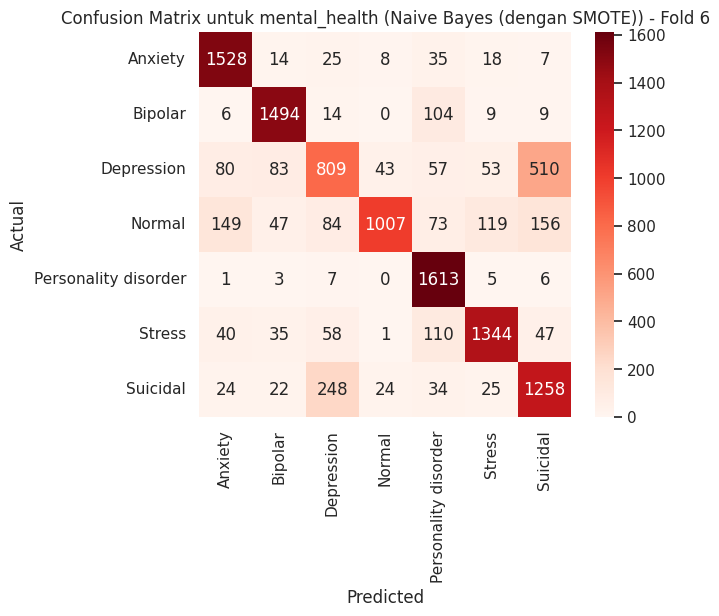


📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (dengan SMOTE)) - Fold 7:
                      precision    recall  f1-score   support

             Anxiety       0.85      0.93      0.89      1635
             Bipolar       0.87      0.92      0.89      1635
          Depression       0.62      0.50      0.55      1635
              Normal       0.92      0.63      0.75      1635
Personality disorder       0.81      0.99      0.89      1636
              Stress       0.84      0.82      0.83      1635
            Suicidal       0.64      0.75      0.69      1635

            accuracy                           0.79     11446
           macro avg       0.79      0.79      0.78     11446
        weighted avg       0.79      0.79      0.78     11446

Akurasi: 79.03%


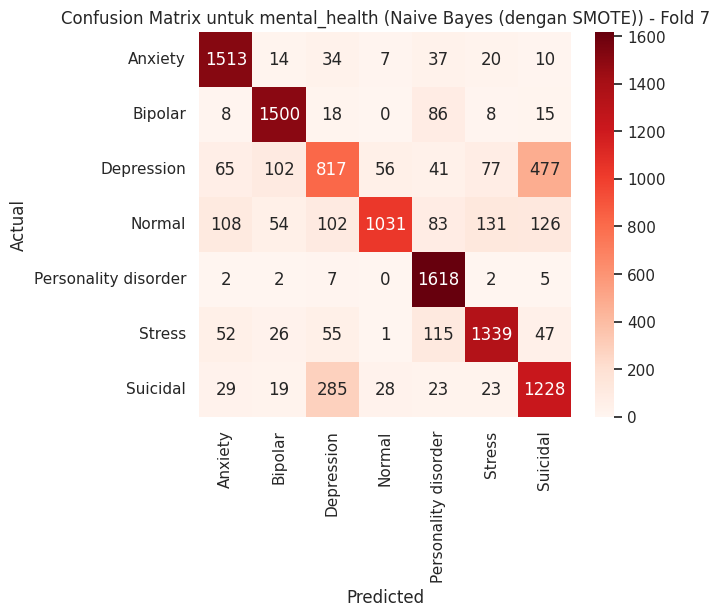


📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (dengan SMOTE)) - Fold 8:
                      precision    recall  f1-score   support

             Anxiety       0.85      0.92      0.88      1635
             Bipolar       0.88      0.91      0.89      1635
          Depression       0.67      0.50      0.57      1635
              Normal       0.90      0.64      0.75      1635
Personality disorder       0.81      0.99      0.89      1635
              Stress       0.85      0.84      0.85      1635
            Suicidal       0.65      0.78      0.71      1635

            accuracy                           0.80     11445
           macro avg       0.80      0.80      0.79     11445
        weighted avg       0.80      0.80      0.79     11445

Akurasi: 79.90%


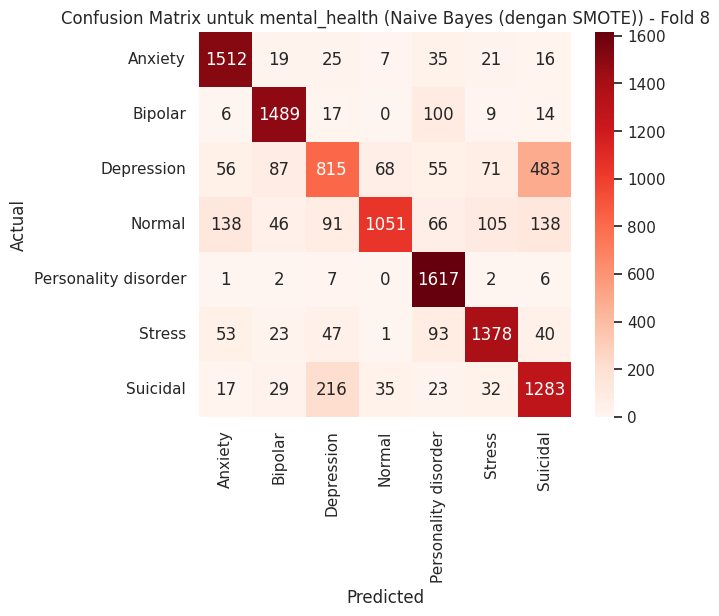


📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (dengan SMOTE)) - Fold 9:
                      precision    recall  f1-score   support

             Anxiety       0.86      0.94      0.90      1635
             Bipolar       0.88      0.91      0.89      1635
          Depression       0.66      0.51      0.58      1635
              Normal       0.91      0.65      0.76      1635
Personality disorder       0.82      0.99      0.89      1635
              Stress       0.85      0.84      0.85      1635
            Suicidal       0.66      0.77      0.71      1635

            accuracy                           0.80     11445
           macro avg       0.81      0.80      0.80     11445
        weighted avg       0.81      0.80      0.80     11445

Akurasi: 80.28%


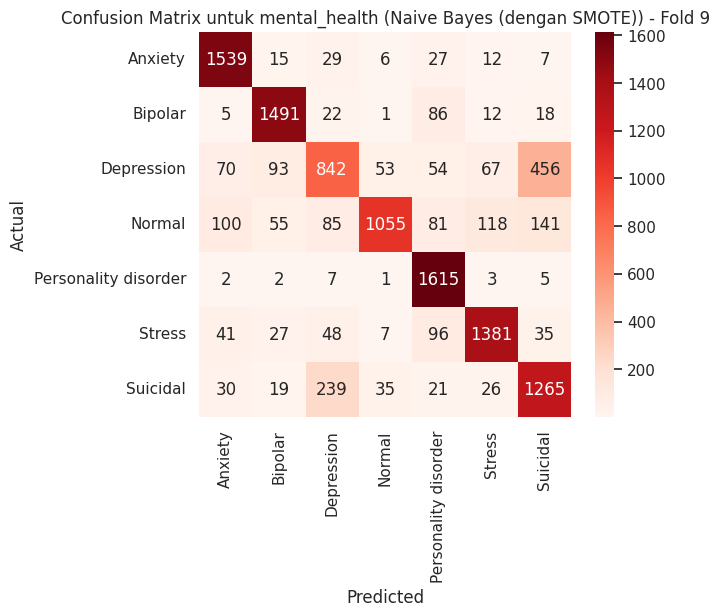


📋 Laporan Klasifikasi untuk mental_health (Naive Bayes (dengan SMOTE)) - Fold 10:
                      precision    recall  f1-score   support

             Anxiety       0.85      0.92      0.89      1635
             Bipolar       0.87      0.91      0.89      1635
          Depression       0.64      0.50      0.56      1635
              Normal       0.91      0.66      0.76      1635
Personality disorder       0.81      0.99      0.89      1635
              Stress       0.84      0.83      0.84      1635
            Suicidal       0.64      0.76      0.70      1635

            accuracy                           0.80     11445
           macro avg       0.80      0.80      0.79     11445
        weighted avg       0.80      0.80      0.79     11445

Akurasi: 79.51%


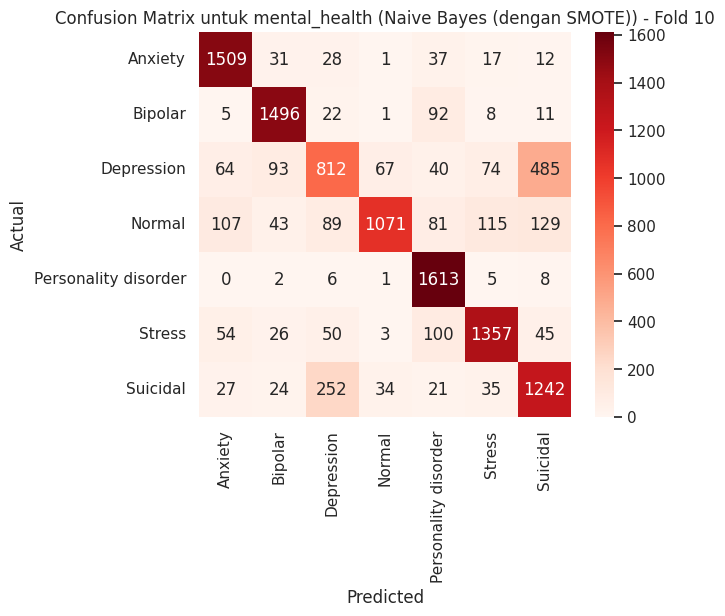


🔹 Rata-rata Hasil K-Fold Cross Validation untuk mental_health (Naive Bayes (dengan SMOTE)):
Precision: 79.55%
Recall: 79.23%
F1-Score: 78.65%
Akurasi: 79.23%
****************************************************************************************************


🔧 Skenario: SVM (tanpa SMOTE)

📋 Laporan Klasifikasi untuk mental_health (SVM (tanpa SMOTE)) - Fold 1:
                      precision    recall  f1-score   support

             Anxiety       0.78      0.73      0.75       389
             Bipolar       0.86      0.68      0.76       288
          Depression       0.64      0.65      0.65      1541
              Normal       0.84      0.93      0.88      1635
Personality disorder       0.62      0.61      0.61       120
              Stress       0.55      0.41      0.47       267
            Suicidal       0.60      0.58      0.59      1065

            accuracy                           0.72      5305
           macro avg       0.70      0.66      0.67      5305
        weigh

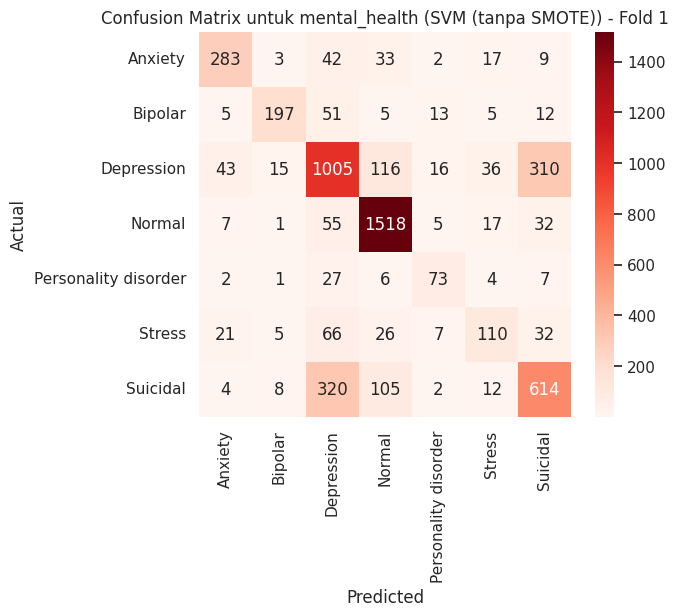


📋 Laporan Klasifikasi untuk mental_health (SVM (tanpa SMOTE)) - Fold 2:
                      precision    recall  f1-score   support

             Anxiety       0.77      0.73      0.75       389
             Bipolar       0.82      0.69      0.75       288
          Depression       0.65      0.65      0.65      1541
              Normal       0.85      0.94      0.89      1635
Personality disorder       0.67      0.70      0.68       120
              Stress       0.63      0.46      0.53       267
            Suicidal       0.59      0.58      0.59      1065

            accuracy                           0.72      5305
           macro avg       0.71      0.68      0.69      5305
        weighted avg       0.72      0.72      0.72      5305

Akurasi: 72.37%


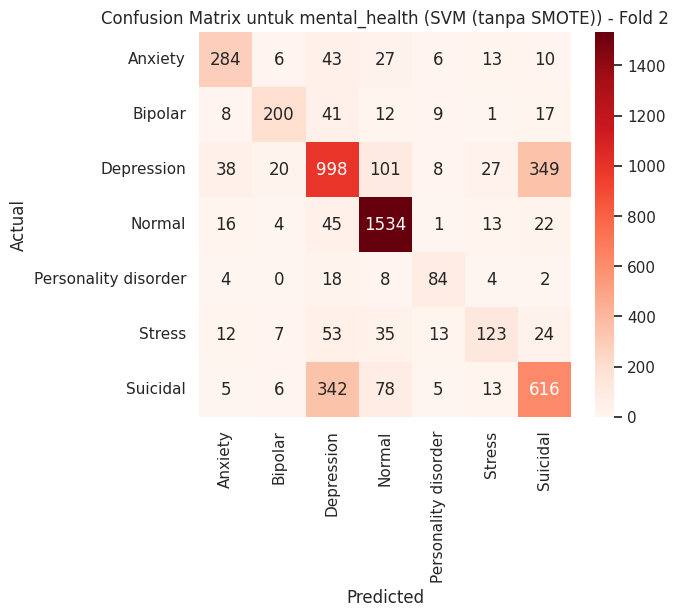


📋 Laporan Klasifikasi untuk mental_health (SVM (tanpa SMOTE)) - Fold 3:
                      precision    recall  f1-score   support

             Anxiety       0.79      0.74      0.76       389
             Bipolar       0.81      0.70      0.75       287
          Depression       0.65      0.66      0.65      1541
              Normal       0.84      0.93      0.88      1635
Personality disorder       0.68      0.63      0.66       121
              Stress       0.59      0.48      0.53       267
            Suicidal       0.61      0.56      0.58      1065

            accuracy                           0.72      5305
           macro avg       0.71      0.67      0.69      5305
        weighted avg       0.72      0.72      0.72      5305

Akurasi: 72.18%


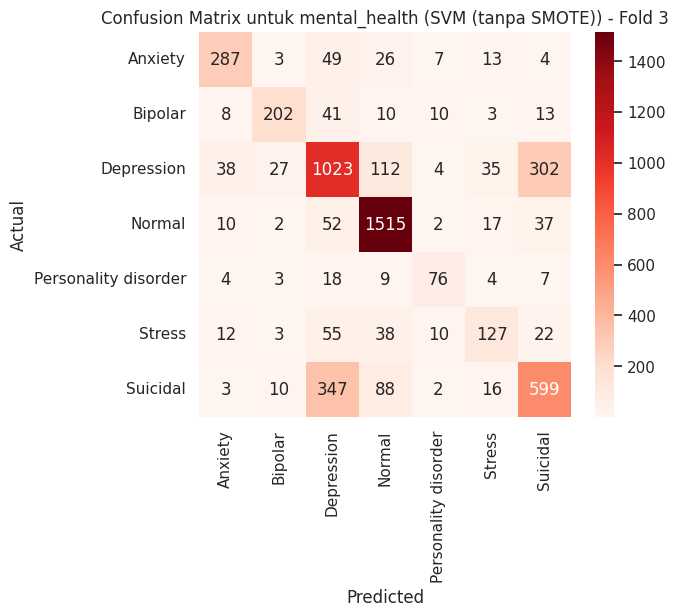


📋 Laporan Klasifikasi untuk mental_health (SVM (tanpa SMOTE)) - Fold 4:
                      precision    recall  f1-score   support

             Anxiety       0.76      0.69      0.72       389
             Bipolar       0.82      0.71      0.76       287
          Depression       0.63      0.64      0.64      1540
              Normal       0.83      0.94      0.88      1635
Personality disorder       0.64      0.58      0.61       120
              Stress       0.53      0.40      0.46       267
            Suicidal       0.58      0.53      0.55      1066

            accuracy                           0.70      5304
           macro avg       0.69      0.64      0.66      5304
        weighted avg       0.70      0.70      0.70      5304

Akurasi: 70.44%


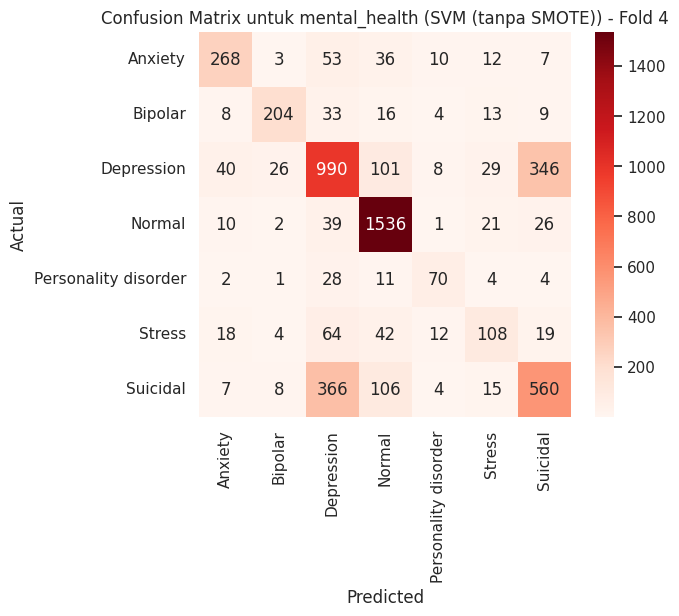


📋 Laporan Klasifikasi untuk mental_health (SVM (tanpa SMOTE)) - Fold 5:
                      precision    recall  f1-score   support

             Anxiety       0.76      0.73      0.75       389
             Bipolar       0.84      0.74      0.79       287
          Depression       0.66      0.64      0.65      1540
              Normal       0.84      0.93      0.88      1635
Personality disorder       0.71      0.66      0.68       120
              Stress       0.57      0.43      0.49       267
            Suicidal       0.60      0.59      0.60      1066

            accuracy                           0.72      5304
           macro avg       0.71      0.68      0.69      5304
        weighted avg       0.72      0.72      0.72      5304

Akurasi: 72.29%


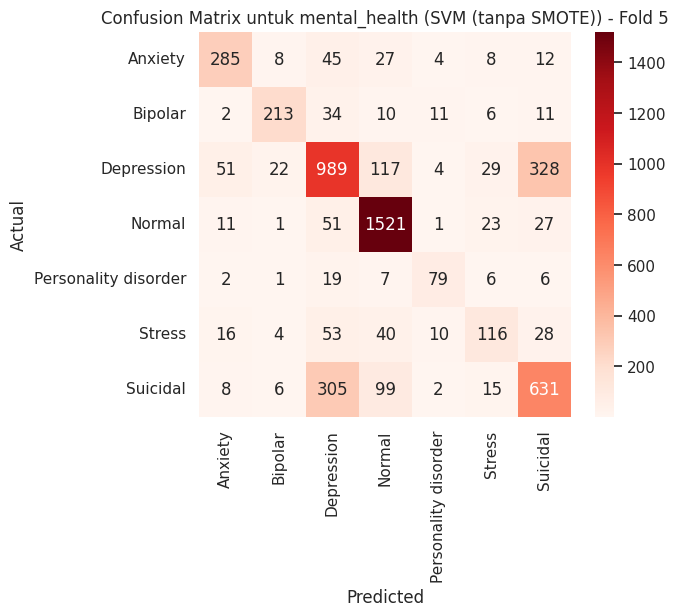


📋 Laporan Klasifikasi untuk mental_health (SVM (tanpa SMOTE)) - Fold 6:
                      precision    recall  f1-score   support

             Anxiety       0.78      0.75      0.76       389
             Bipolar       0.83      0.66      0.74       288
          Depression       0.64      0.66      0.65      1540
              Normal       0.84      0.93      0.88      1635
Personality disorder       0.61      0.65      0.63       120
              Stress       0.62      0.46      0.53       266
            Suicidal       0.59      0.55      0.57      1066

            accuracy                           0.72      5304
           macro avg       0.70      0.67      0.68      5304
        weighted avg       0.71      0.72      0.71      5304

Akurasi: 71.64%


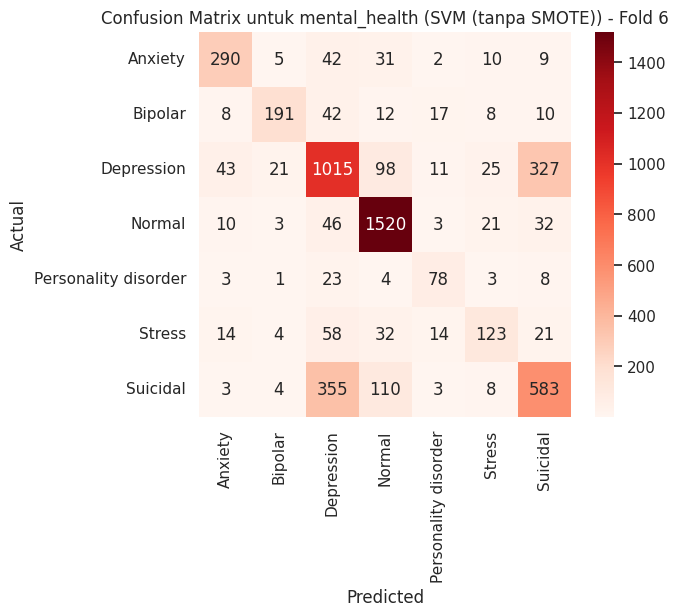


📋 Laporan Klasifikasi untuk mental_health (SVM (tanpa SMOTE)) - Fold 7:
                      precision    recall  f1-score   support

             Anxiety       0.79      0.77      0.78       389
             Bipolar       0.81      0.69      0.75       288
          Depression       0.67      0.65      0.66      1540
              Normal       0.84      0.95      0.89      1635
Personality disorder       0.72      0.59      0.65       120
              Stress       0.56      0.49      0.53       267
            Suicidal       0.61      0.57      0.59      1065

            accuracy                           0.73      5304
           macro avg       0.71      0.67      0.69      5304
        weighted avg       0.72      0.73      0.72      5304

Akurasi: 72.83%


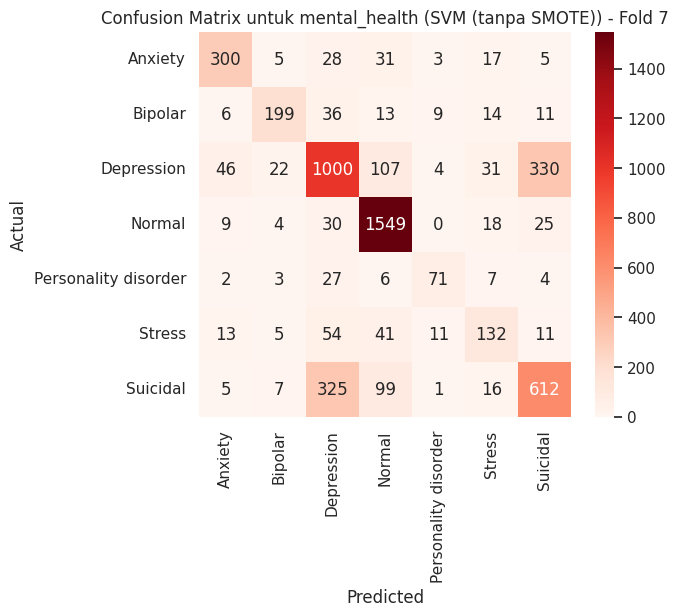


📋 Laporan Klasifikasi untuk mental_health (SVM (tanpa SMOTE)) - Fold 8:
                      precision    recall  f1-score   support

             Anxiety       0.75      0.73      0.74       389
             Bipolar       0.82      0.68      0.74       288
          Depression       0.64      0.63      0.64      1540
              Normal       0.85      0.94      0.89      1635
Personality disorder       0.63      0.65      0.64       120
              Stress       0.66      0.46      0.55       267
            Suicidal       0.57      0.56      0.57      1065

            accuracy                           0.72      5304
           macro avg       0.70      0.67      0.68      5304
        weighted avg       0.71      0.72      0.71      5304

Akurasi: 71.63%


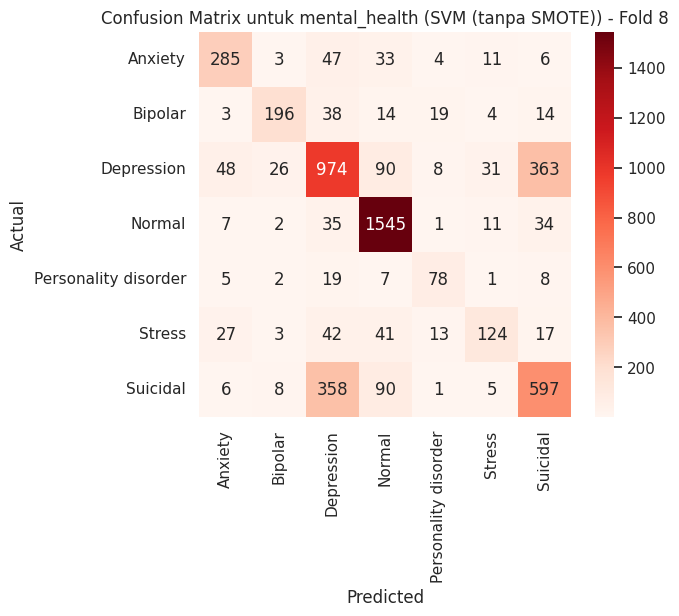


📋 Laporan Klasifikasi untuk mental_health (SVM (tanpa SMOTE)) - Fold 9:
                      precision    recall  f1-score   support

             Anxiety       0.77      0.72      0.75       388
             Bipolar       0.81      0.69      0.74       288
          Depression       0.65      0.66      0.65      1540
              Normal       0.84      0.93      0.88      1636
Personality disorder       0.60      0.62      0.61       120
              Stress       0.54      0.40      0.46       267
            Suicidal       0.59      0.56      0.58      1065

            accuracy                           0.72      5304
           macro avg       0.69      0.66      0.67      5304
        weighted avg       0.71      0.72      0.71      5304

Akurasi: 71.57%


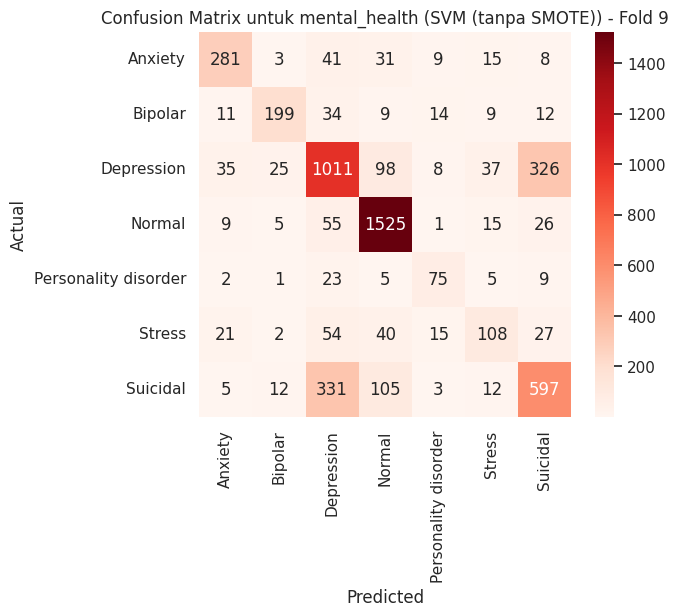


📋 Laporan Klasifikasi untuk mental_health (SVM (tanpa SMOTE)) - Fold 10:
                      precision    recall  f1-score   support

             Anxiety       0.79      0.70      0.74       388
             Bipolar       0.86      0.69      0.76       288
          Depression       0.64      0.65      0.64      1541
              Normal       0.83      0.94      0.88      1635
Personality disorder       0.63      0.63      0.63       120
              Stress       0.59      0.42      0.49       267
            Suicidal       0.59      0.56      0.58      1065

            accuracy                           0.72      5304
           macro avg       0.70      0.66      0.68      5304
        weighted avg       0.71      0.72      0.71      5304

Akurasi: 71.55%


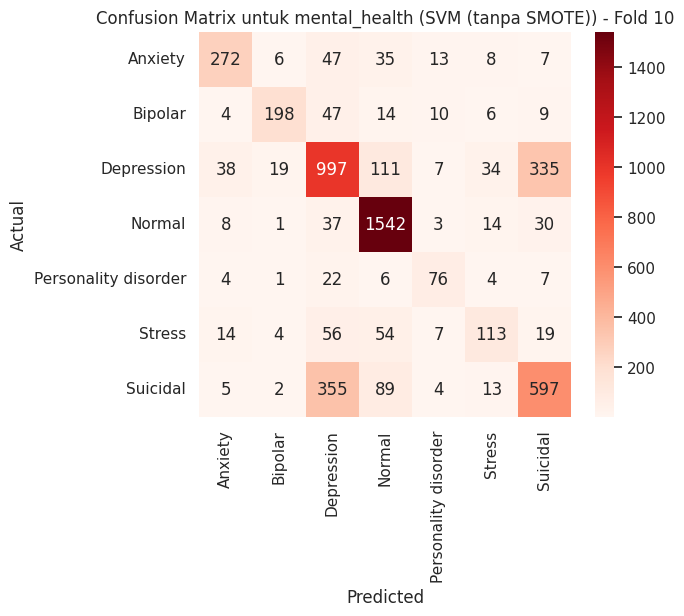


🔹 Rata-rata Hasil K-Fold Cross Validation untuk mental_health (SVM (tanpa SMOTE)):
Precision: 70.29%
Recall: 66.42%
F1-Score: 68.05%
Akurasi: 71.81%
****************************************************************************************************


🔧 Skenario: SVM (dengan SMOTE)


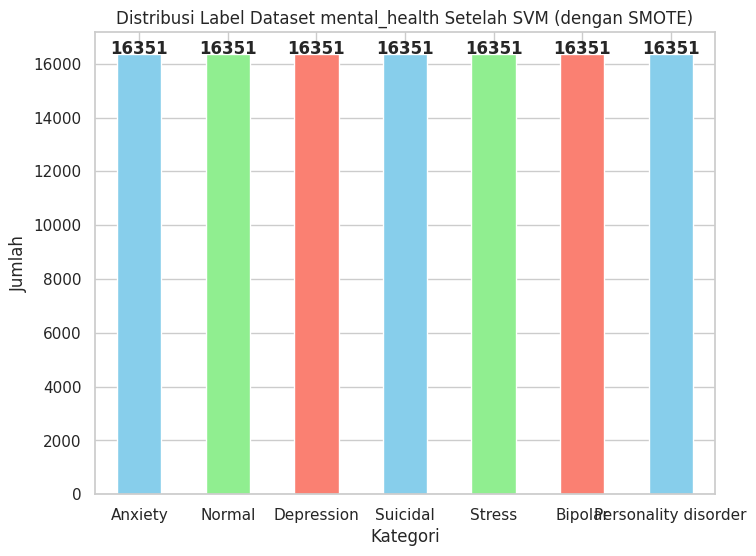


📋 Laporan Klasifikasi untuk mental_health (SVM (dengan SMOTE)) - Fold 1:
                      precision    recall  f1-score   support

             Anxiety       0.95      0.97      0.96      1636
             Bipolar       0.96      0.93      0.95      1635
          Depression       0.74      0.61      0.67      1635
              Normal       0.82      0.82      0.82      1635
Personality disorder       0.87      1.00      0.93      1635
              Stress       0.87      0.89      0.88      1635
            Suicidal       0.72      0.73      0.73      1635

            accuracy                           0.85     11446
           macro avg       0.85      0.85      0.85     11446
        weighted avg       0.85      0.85      0.85     11446

Akurasi: 85.08%


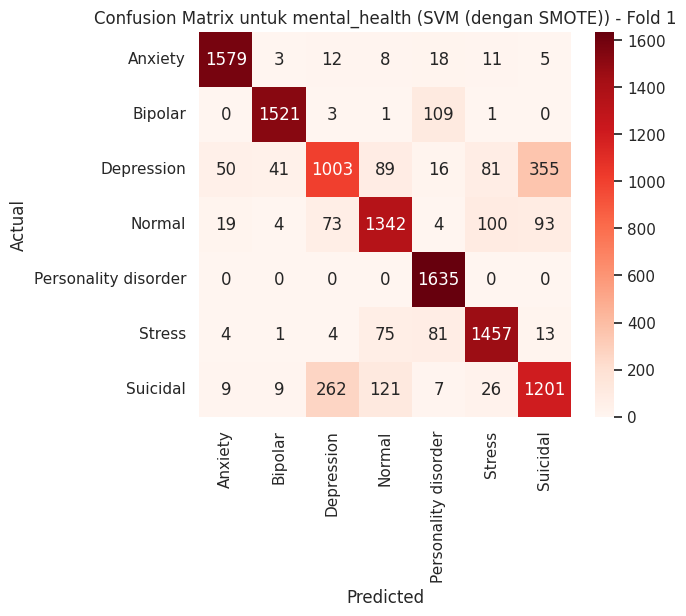


📋 Laporan Klasifikasi untuk mental_health (SVM (dengan SMOTE)) - Fold 2:
                      precision    recall  f1-score   support

             Anxiety       0.96      0.96      0.96      1635
             Bipolar       0.94      0.93      0.94      1635
          Depression       0.75      0.61      0.67      1635
              Normal       0.81      0.80      0.80      1636
Personality disorder       0.86      1.00      0.92      1635
              Stress       0.87      0.89      0.88      1635
            Suicidal       0.71      0.72      0.72      1635

            accuracy                           0.84     11446
           macro avg       0.84      0.84      0.84     11446
        weighted avg       0.84      0.84      0.84     11446

Akurasi: 84.44%


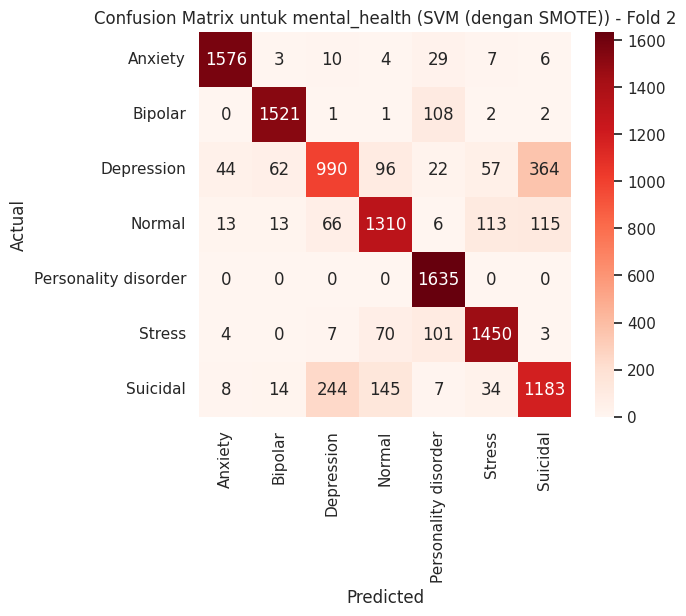


📋 Laporan Klasifikasi untuk mental_health (SVM (dengan SMOTE)) - Fold 3:
                      precision    recall  f1-score   support

             Anxiety       0.94      0.97      0.96      1635
             Bipolar       0.95      0.93      0.94      1635
          Depression       0.73      0.60      0.66      1636
              Normal       0.83      0.80      0.82      1635
Personality disorder       0.87      1.00      0.93      1635
              Stress       0.87      0.89      0.88      1635
            Suicidal       0.71      0.72      0.72      1635

            accuracy                           0.85     11446
           macro avg       0.84      0.85      0.84     11446
        weighted avg       0.84      0.85      0.84     11446

Akurasi: 84.52%


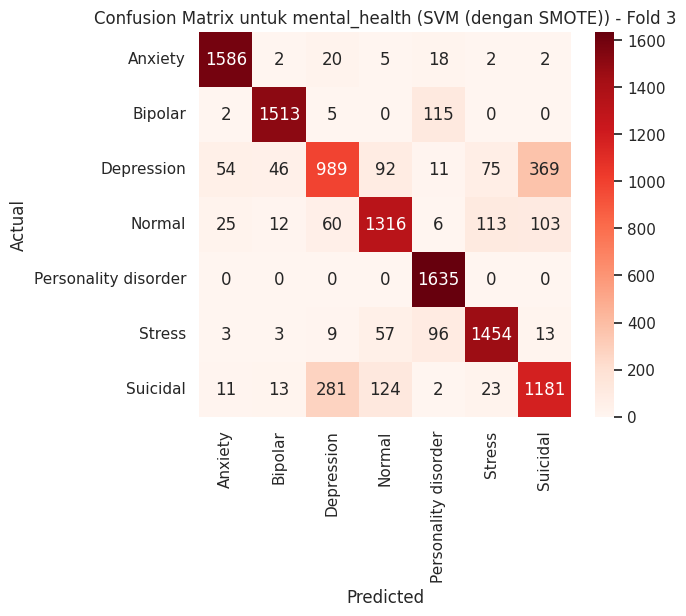


📋 Laporan Klasifikasi untuk mental_health (SVM (dengan SMOTE)) - Fold 4:
                      precision    recall  f1-score   support

             Anxiety       0.95      0.97      0.96      1635
             Bipolar       0.96      0.92      0.94      1635
          Depression       0.72      0.60      0.65      1635
              Normal       0.80      0.81      0.81      1635
Personality disorder       0.87      1.00      0.93      1635
              Stress       0.89      0.89      0.89      1635
            Suicidal       0.70      0.71      0.71      1636

            accuracy                           0.84     11446
           macro avg       0.84      0.84      0.84     11446
        weighted avg       0.84      0.84      0.84     11446

Akurasi: 84.28%


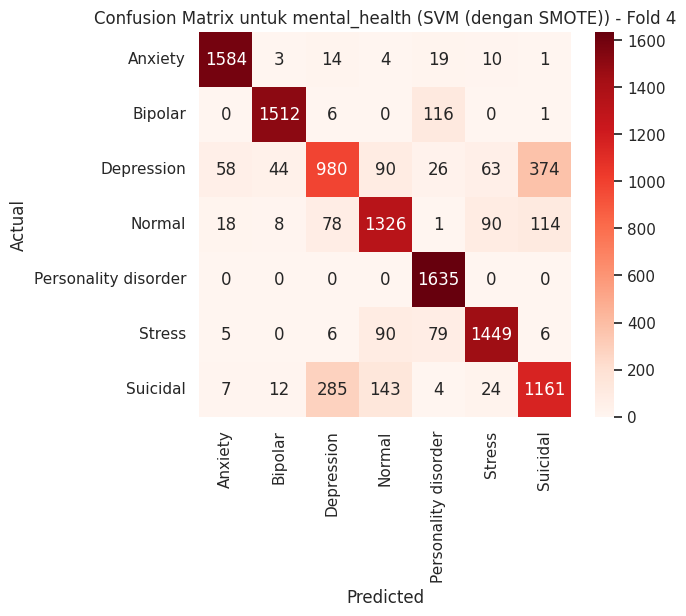


📋 Laporan Klasifikasi untuk mental_health (SVM (dengan SMOTE)) - Fold 5:
                      precision    recall  f1-score   support

             Anxiety       0.95      0.97      0.96      1635
             Bipolar       0.96      0.94      0.95      1635
          Depression       0.71      0.59      0.65      1635
              Normal       0.81      0.81      0.81      1635
Personality disorder       0.88      1.00      0.94      1635
              Stress       0.88      0.88      0.88      1636
            Suicidal       0.69      0.72      0.71      1635

            accuracy                           0.84     11446
           macro avg       0.84      0.84      0.84     11446
        weighted avg       0.84      0.84      0.84     11446

Akurasi: 84.40%


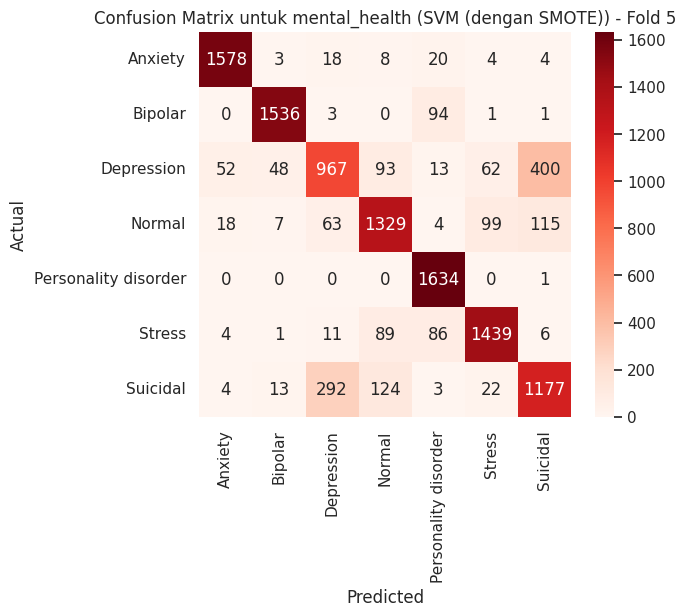


📋 Laporan Klasifikasi untuk mental_health (SVM (dengan SMOTE)) - Fold 6:
                      precision    recall  f1-score   support

             Anxiety       0.95      0.96      0.95      1635
             Bipolar       0.95      0.93      0.94      1636
          Depression       0.75      0.61      0.67      1635
              Normal       0.83      0.81      0.82      1635
Personality disorder       0.87      1.00      0.93      1635
              Stress       0.88      0.90      0.89      1635
            Suicidal       0.71      0.74      0.72      1635

            accuracy                           0.85     11446
           macro avg       0.85      0.85      0.85     11446
        weighted avg       0.85      0.85      0.85     11446

Akurasi: 85.01%


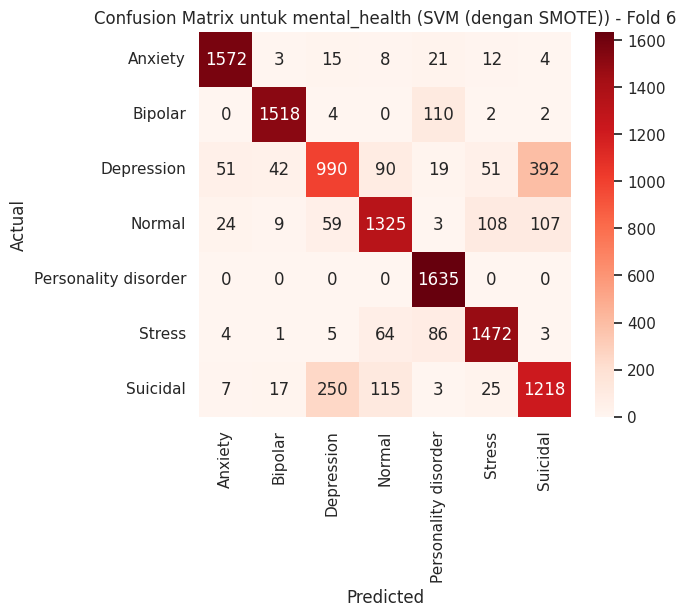


📋 Laporan Klasifikasi untuk mental_health (SVM (dengan SMOTE)) - Fold 7:
                      precision    recall  f1-score   support

             Anxiety       0.95      0.96      0.96      1635
             Bipolar       0.96      0.94      0.95      1635
          Depression       0.73      0.61      0.67      1635
              Normal       0.81      0.80      0.81      1635
Personality disorder       0.88      1.00      0.94      1636
              Stress       0.86      0.89      0.87      1635
            Suicidal       0.71      0.72      0.72      1635

            accuracy                           0.85     11446
           macro avg       0.84      0.85      0.84     11446
        weighted avg       0.84      0.85      0.84     11446

Akurasi: 84.76%


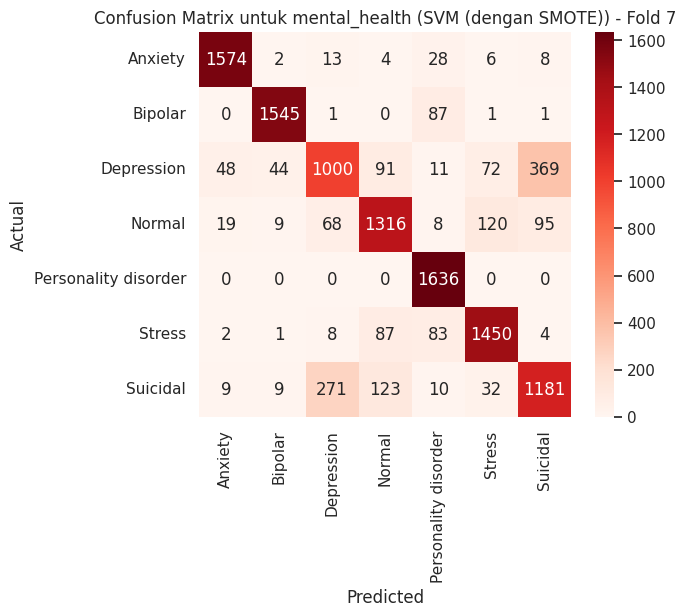


📋 Laporan Klasifikasi untuk mental_health (SVM (dengan SMOTE)) - Fold 8:
                      precision    recall  f1-score   support

             Anxiety       0.96      0.97      0.96      1635
             Bipolar       0.96      0.93      0.94      1635
          Depression       0.75      0.61      0.68      1635
              Normal       0.80      0.80      0.80      1635
Personality disorder       0.87      1.00      0.93      1635
              Stress       0.87      0.90      0.88      1635
            Suicidal       0.72      0.74      0.73      1635

            accuracy                           0.85     11445
           macro avg       0.85      0.85      0.85     11445
        weighted avg       0.85      0.85      0.85     11445

Akurasi: 85.04%


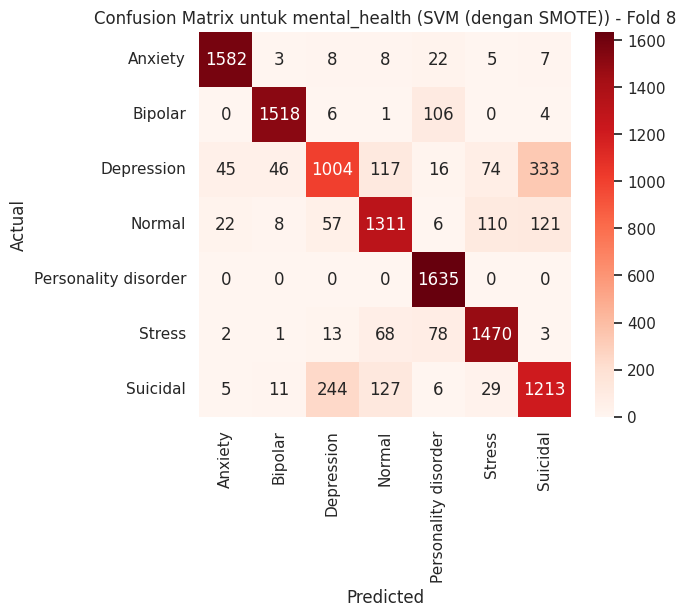


📋 Laporan Klasifikasi untuk mental_health (SVM (dengan SMOTE)) - Fold 9:
                      precision    recall  f1-score   support

             Anxiety       0.95      0.96      0.95      1635
             Bipolar       0.96      0.94      0.95      1635
          Depression       0.74      0.61      0.67      1635
              Normal       0.81      0.81      0.81      1635
Personality disorder       0.89      1.00      0.94      1635
              Stress       0.87      0.89      0.88      1635
            Suicidal       0.71      0.74      0.72      1635

            accuracy                           0.85     11445
           macro avg       0.85      0.85      0.85     11445
        weighted avg       0.85      0.85      0.85     11445

Akurasi: 84.94%


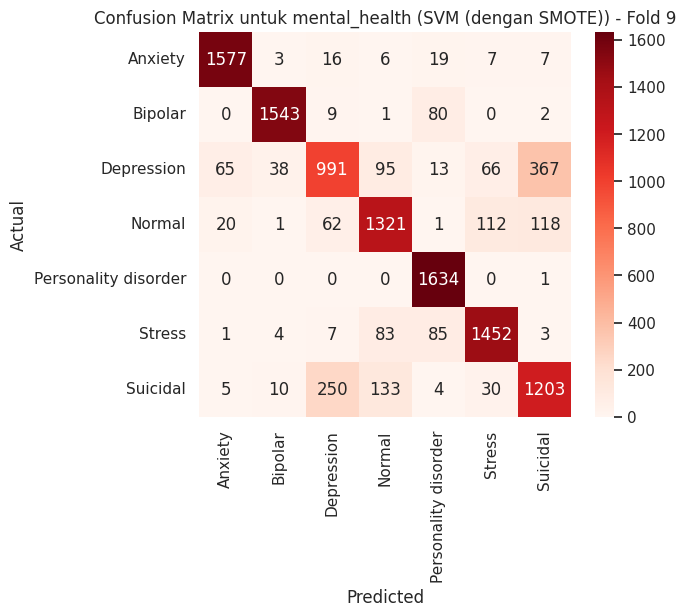


📋 Laporan Klasifikasi untuk mental_health (SVM (dengan SMOTE)) - Fold 10:
                      precision    recall  f1-score   support

             Anxiety       0.95      0.96      0.95      1635
             Bipolar       0.96      0.94      0.95      1635
          Depression       0.75      0.62      0.68      1635
              Normal       0.81      0.83      0.82      1635
Personality disorder       0.88      1.00      0.94      1635
              Stress       0.87      0.89      0.88      1635
            Suicidal       0.71      0.72      0.72      1635

            accuracy                           0.85     11445
           macro avg       0.85      0.85      0.85     11445
        weighted avg       0.85      0.85      0.85     11445

Akurasi: 85.03%


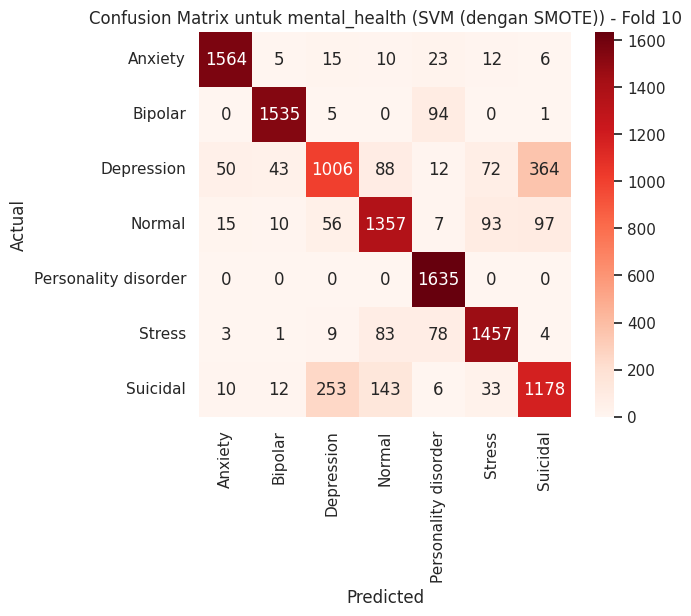


🔹 Rata-rata Hasil K-Fold Cross Validation untuk mental_health (SVM (dengan SMOTE)):
Precision: 84.48%
Recall: 84.75%
F1-Score: 84.46%
Akurasi: 84.75%
****************************************************************************************************



In [13]:
# Final Modeling Script (Mental Health Dataset Only)

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import MaxAbsScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Path ke dataset
processed_path = "/content/drive/MyDrive/Capstone/dataset/processed/"

# Mapping nama file ke nama dataset
processed_datasets = {
    "mental_health_processed.csv": "mental_health"
}

# Fungsi visualisasi distribusi label
def visualize_label_distribution(dataset, label_column, title):
    label_counts = dataset[label_column].value_counts()
    plt.figure(figsize=(8, 6))
    label_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
    for i, count in enumerate(label_counts):
        plt.text(i, count + 5, str(count), ha='center', fontsize=12, fontweight='bold')
    plt.title(title)
    plt.xlabel("Kategori")
    plt.ylabel("Jumlah")
    plt.xticks(rotation=0)
    plt.show()

# Dictionary menyimpan hasil akhir
results = {}

# ✅ Pastikan tfidf_results tersedia
if 'tfidf_results' not in globals():
    raise ValueError("❌ Variabel tfidf_results belum tersedia. Jalankan proses TF-IDF terlebih dahulu!")

# Mulai modeling
for file, dataset_name in processed_datasets.items():
    print(f"\n⚙️ Memproses dataset: {dataset_name} ({file})")

    # Load ulang file CSV asli untuk ambil label
    df = pd.read_csv(processed_path + file, encoding="latin-1")
    label_col = [col for col in df.columns if col.startswith("label")][0]

    # Visualisasi awal label
    visualize_label_distribution(df, label_col, f"Distribusi Label Dataset {dataset_name} Sebelum Oversampling")

    # Cek TF-IDF
    if file not in tfidf_results:
        print(f"⚠️ TF-IDF untuk {file} tidak ditemukan. Lewati.")
        continue

    # Ambil fitur & label
    X_tfidf = tfidf_results[file]
    y = df[label_col]
    X_scaled = MaxAbsScaler().fit_transform(X_tfidf)

    # Skenario model
    scenarios = {
        "Naive Bayes (tanpa SMOTE)": (MultinomialNB(), None),
        "Naive Bayes (dengan SMOTE)": (MultinomialNB(), SMOTE(random_state=42)),
        "SVM (tanpa SMOTE)": (LinearSVC(), None),
        "SVM (dengan SMOTE)": (LinearSVC(), SMOTE(random_state=42))
    }

    for method_name, (model, oversampler) in scenarios.items():
        print(f"\n🔧 Skenario: {method_name}")

        if oversampler:
            X_resampled, y_resampled = oversampler.fit_resample(X_scaled, y)
            visualize_label_distribution(
                pd.DataFrame(y_resampled, columns=[label_col]),
                label_col,
                f"Distribusi Label Dataset {dataset_name} Setelah {method_name}"
            )
        else:
            X_resampled, y_resampled = X_scaled, y

        # Grid Search untuk Naive Bayes
        if isinstance(model, MultinomialNB):
            grid = GridSearchCV(model, {'alpha': [0.05, 0.1, 0.5, 1.0]}, cv=5)
            grid.fit(X_resampled, y_resampled)
            model = MultinomialNB(alpha=grid.best_params_['alpha'])
            best_alpha = grid.best_params_['alpha']
        else:
            best_alpha = "-"

        # 10-Fold CV
        kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        y_true_all, y_pred_all = [], []
        accuracies, reports = [], []

        for fold, (train_idx, test_idx) in enumerate(kf.split(X_resampled, y_resampled)):
            X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
            y_train, y_test = np.array(y_resampled)[train_idx], np.array(y_resampled)[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            y_true_all.extend(y_test)
            y_pred_all.extend(y_pred)
            acc = accuracy_score(y_test, y_pred)
            accuracies.append(acc)
            report = classification_report(y_test, y_pred, output_dict=True)
            reports.append(report)

            print(f"\n📋 Laporan Klasifikasi untuk {dataset_name} ({method_name}) - Fold {fold+1}:")
            print(classification_report(y_test, y_pred))
            print(f"Akurasi: {acc * 100:.2f}%")

            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title(f"Confusion Matrix untuk {dataset_name} ({method_name}) - Fold {fold+1}")
            plt.show()

        # Hitung rata-rata
        avg_precision = np.mean([r['macro avg']['precision'] for r in reports])
        avg_recall = np.mean([r['macro avg']['recall'] for r in reports])
        avg_f1_score = np.mean([r['macro avg']['f1-score'] for r in reports])
        avg_accuracy = np.mean(accuracies)

        results[f"{dataset_name} ({method_name})"] = {
            "Best Alpha": best_alpha,
            "Avg Precision": avg_precision * 100,
            "Avg Recall": avg_recall * 100,
            "Avg F1-Score": avg_f1_score * 100,
            "Avg Accuracy": avg_accuracy * 100
        }

        print(f"\n🔹 Rata-rata Hasil K-Fold Cross Validation untuk {dataset_name} ({method_name}):")
        print(f"Precision: {results[f'{dataset_name} ({method_name})']['Avg Precision']:.2f}%")
        print(f"Recall: {results[f'{dataset_name} ({method_name})']['Avg Recall']:.2f}%")
        print(f"F1-Score: {results[f'{dataset_name} ({method_name})']['Avg F1-Score']:.2f}%")
        print(f"Akurasi: {results[f'{dataset_name} ({method_name})']['Avg Accuracy']:.2f}%")

        print(f"{'*'*100}\n")


####Summarization

Memberikan AI-supported summarization otomatis dari semua percobaan modeling.

In [14]:
# 🔍 Summarization dari seluruh hasil modeling

# Konversi dictionary `results` ke DataFrame untuk ringkasan
summary_df = pd.DataFrame.from_dict(results, orient='index')

# Ubah index menjadi kolom terpisah agar mudah dibaca
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Model'}, inplace=True)

# Urutkan berdasarkan F1-Score tertinggi
summary_df = summary_df.sort_values(by="Avg F1-Score", ascending=False)

# Tampilkan ringkasan
print("\n📊 Ringkasan Hasil Evaluasi Semua Skenario:")
display(summary_df)


📊 Ringkasan Hasil Evaluasi Semua Skenario:


,Model,Best Alpha,Avg Precision,Avg Recall,Avg F1-Score,Avg Accuracy
3,mental_health (SVM (dengan SMOTE)),-,84.482569,84.749771,84.457732,84.749738
1,mental_health (Naive Bayes (dengan SMOTE)),0.05,79.550169,79.234108,78.647653,79.234140
2,mental_health (SVM (tanpa SMOTE)),-,70.286830,66.422287,68.050058,71.811535
0,mental_health (Naive Bayes (tanpa SMOTE)),0.1,57.150208,56.591341,56.033505,62.138268


Hasil menunjukkan bahwa model SVM dengan SMOTE memberikan performa terbaik, dengan rata-rata F1-Score sebesar 84.46% dan akurasi sebesar 84.75%. Hal ini menunjukkan bahwa penggunaan SMOTE (Synthetic Minority Oversampling Technique) sebagai teknik pembelajaran mesin berbasis AI secara signifikan membantu menyeimbangkan distribusi kelas yang tidak seimbang, sehingga meningkatkan performa model secara keseluruhan. Sebaliknya, skenario Naïve Bayes tanpa SMOTE menunjukkan performa paling rendah dengan F1-Score hanya sebesar 56.03%, yang mengindikasikan bahwa model ini kurang mampu menangani distribusi kelas yang tidak seimbang secara optimal.

Dengan demikian, dapat disimpulkan bahwa:

*   Algoritma SVM lebih unggul dibandingkan Naïve Bayes pada dataset ini.
*   Penggunaan teknik oversampling berupa SMOTE efektif meningkatkan akurasi dan stabilitas model, terutama dalam kondisi distribusi data yang tidak seimbang.